# Figure 4 - Estimate M PCA

updated: May 15, 2022

This notebook was created after a long meeting with James on Sunday May 15

Method 1 (maybe illustrate with schematic) for estimating M_hat: PCA + Regression. 
1. Pretrain RNN with Wfb=M and Wbmi0 and corr(M, Wbmi0^T) = 0.9.
2. Do PCA on the trained RNN, keeping the top 10 PCs.
3. Use regression to relate h to y. The PCs and regression coefficients define Mhat.

location: `rnn-learning/experiments/NeurIPS-2022-5-16/Fig4-Estimate-M-PCA-2022-5-16.ipynb`


In [1]:
pwd

'/Users/jacobportes/Documents/Code/rnn-learning/experiments/NeurIPS-2022-5-16'

In [1]:
folder = 'figs-2022-5-18/'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator,FixedFormatter
import matplotlib.pylab as pylab

# analysis
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from scipy import interpolate # don't import stats
from scipy import linalg as LA
from scipy.ndimage.filters import uniform_filter1d

# miscellaneous
from tqdm import tqdm
from itertools import cycle
from copy import deepcopy
import pickle

import logging
import warnings
import dataclasses
from dataclasses import dataclass
from typing import Optional, List

import sys
sys.path.append("../..")

In [3]:
from rnn import RNNparams, RNN
from task import Task
from simulation import Simulation
from algorithms.bptt import BPTT
from algorithms.rflo import RFLO
from algorithms.reinforce import REINFORCE
from algorithms.track_vars import TrackVars
from algorithms.weight_mirror import WeightMirror

from utils.plotting import plot_trained_trajectories, paper_format
from utils.metric import cos_sim, return_norm_and_angle
from utils.functions import choose_aligned_matrix

from utils.metric import cos_sim, flow_field_data, flow_field_predicted, calculate_flow_field_correlation


In [4]:
trial_duration = 20
n_in=4
frac_on = 0.4

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

In [ ]:
""" Vary Scale of Wfb """
seeds = [1,2,34]
overlap = 0.4
n_change = 60
scales_w_fb = [0.01,1,5]#,2,10]

corr_dict = {}
corr_dict['angle1'] = []
corr_dict['angle2'] = []

for seed in seeds:
    angle1_list = []
    angle2_list = []
    
    """ vary scale of driving feedback and """
    for scale in scales_w_fb:
        
        print('>> SCALE {}'.format(scale))
        
        


        # Set RNN Parameters
        params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
                       eta_in=0.1,eta_rec=0.2,eta_out=0.1,eta_fb=0.1,g_fb=2,
                       sig_in=0.0,sig_rec=0.1,sig_out=0.01,sig_fb=0.1,
                       velocity_transform=False, tau_vel = 0.8, dt_vel = 0.1,
                       driving_feedback=True,
                       rng=np.random.RandomState(84))
        #params.print_params()

        # Initialize RNN
        net0 = RNN(params)

        w_m = choose_aligned_matrix(net0.w_out.T,n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)
        net0.set_weights(w_m = w_m, w_fb = scale*w_m)
        
        sim0 = Simulation(net0)

        rflo = RFLO(net0,apply_to=['w_rec'],online=False)
        sim0.run_session(n_trials=1000, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['loss','h'], plot=True, plot_freq=20)

        fig0 = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4],title='Pretrain RFLO, train '+r'$W_{rec}$')
        
        norm, angle = return_norm_and_angle(net0.w_out,net0.w_fb.T)
        print('\nw_out0 norm: {:.2f}'.format(norm) + '\t w_out0 vs. w_fb angle: {:.2f}'.format(angle),end='')


        """ Apply PCA to static activity, Estimate Mhat """
        net0_post = RNN(params)
        net0_post.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy(),w_fb = net0.w_fb.copy(),w_m = net0.w_m.copy())
        sim0_post = Simulation(net0_post)
        trackvars = TrackVars(net0_post,apply_to=[]) 
        sim0_post.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err','pos'], plot=False, plot_freq=10)

        
        """ Apply PCA """
        # concatenate data
        activity = sim0_post.session_probes['h'][0].squeeze()

        for i in range(1,len(sim0_post.session_probes['h'])):
            activity = np.vstack((activity,sim0_post.session_probes['h'][i].squeeze()))

        pca = PCA(n_components=10)
        pca.fit(activity)
        C = pca.components_
        
        fig,ax = plt.subplots(1,1)
        plt.plot(pca.explained_variance_ratio_,'o-')
        plt.ylabel('explained variance')
        plt.xlabel('PC')
        plt.show()


        """ Compare with cursor location """
        pos = sim0_post.session_probes['pos'][0].squeeze()

        for i in range(1,len(sim0_post.session_probes['pos'])):
            pos = np.vstack((pos,sim0_post.session_probes['pos'][i].squeeze()))

        lr = LinearRegression(fit_intercept=False)
        lr.fit((C @ activity.T).T, pos)
        D = lr.coef_
        
        Mhat = (D@C).T
        
        """ Test new decoder """

        net1 = RNN(params)


        if net0.w_fb.any():
            net1.set_weights(w_in=np.copy(net0.w_in),w_rec=np.copy(net0.w_rec),w_fb=np.copy(net0.w_fb))
        else:
            net1.set_weights(w_in=np.copy(net0.w_in),w_rec=np.copy(net0.w_rec))

        net1.set_weights(w_out=D@C) # set w_out and w_m

        # initialize simulation, no learning here
        sim1 = Simulation(net1)
       
        sim1.run_session(n_trials=100, tasks=[task1,task2,task3,task4], learn_alg=[], probe_types=['h','y_out','pos'], plot=True, plot_freq=1,train=False)


        fig = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4],title='sim0')

        fig = plot_trained_trajectories(sim=sim1, tasks=[task1,task2,task3,task4],title='sim1')



        norm, angle = return_norm_and_angle(Mhat.T,net0.w_out)
        print('\nMhat norm: {:.2f}'.format(norm) + '\t w_out0 vs. Mhat angle: {:.2f}'.format(angle),end='')
        angle1_list.append(angle)
        
        norm, angle = return_norm_and_angle(net0.w_m,Mhat)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_m vs. Mhat angle: {:.2f}'.format(angle),end='')
        angle2_list.append(angle)
        
    corr_dict['angle1'].append(angle1_list)
    corr_dict['angle2'].append(angle2_list)


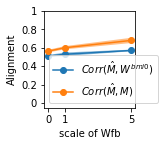

In [41]:
""" Vary Alignment between Wbmi0 and Wbmi1 """
paper = False
save = False

    

fig,ax=plt.subplots()
n_samples = np.asarray(corr_dict['angle1']).shape[0]
mn1 = np.mean(np.asarray(corr_dict['angle1']),axis=0)
mn2 = np.mean(np.asarray(corr_dict['angle2']),axis=0)
std1 = np.std(np.asarray(corr_dict['angle1']),axis=0)
std2 = np.std(np.asarray(corr_dict['angle2']),axis=0)
sem1 = std1/np.sqrt(n_samples)
sem2 = std2/np.sqrt(n_samples)
plt.plot(scales_w_fb,mn1,'o-',label=r'$Corr(\hat{M},W^{bmi0})$')
plt.fill_between(scales_w_fb,mn1-sem1,mn1+sem1,alpha=0.5)
plt.plot(scales_w_fb,mn2,'o-',label=r'$Corr(\hat{M},M)$')
plt.fill_between(scales_w_fb,mn2-sem2,mn2+sem2,alpha=0.5)
plt.xlabel('scale of Wfb')
plt.ylabel('Alignment')
plt.ylim([0,1])
plt.legend()

if paper:
    fig,ax = paper_format(fig=fig,ax=ax,xlabels=[0,1,5],ylabels=[0,0.2,0.4,0.6,0.8,1],linewidth=2,ylim=[-0.05,1],figsize=(2.25,2.25))

plt.show()

if save:
    fig.savefig(folder+'PCA-estimate-Mhat-v2.pdf')

In [ ]:
""" Vary Scale of Wfb """
seeds = [1,2,34]
overlap = 0.6
n_change = 30
scale = 5
#train_durations = [500,1000,2000]
train_duration = 1000
#sig_rec_noise = [0.05,0.1,0.5]
sig_rec = 0.1
test_duration = 100#,500,1000]
pca_components = [1,2,3,4,5,6,7,8]

corr_dict = {}
corr_dict['angle1'] = []
corr_dict['angle2'] = []

for seed in seeds:
    angle1_list = []
    angle2_list = []
    
    #     """ vary scale of driving feedback and """
    #     for train_duration in train_durations:
    #     """ vary scale of noise"""
    #     for sig_rec in sig_rec_noise:
    #""" vary test_duration """
    #for test_duration in test_durations:
    """ vary PCA """
    for n_components in pca_components:
        
        print('>> Train Duration {}'.format(train_duration))
        
        


        # Set RNN Parameters
        params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
                       eta_in=0.1,eta_rec=0.2,eta_out=0.1,eta_fb=0.1,g_fb=2,
                       sig_in=0.0,sig_rec=sig_rec,sig_out=0.01,sig_fb=0.1,
                       velocity_transform=False, tau_vel = 0.8, dt_vel = 0.1,
                       driving_feedback=True,
                       rng=np.random.RandomState(84))
        #params.print_params()

        # Initialize RNN
        net0 = RNN(params)

        w_m = choose_aligned_matrix(net0.w_out.T,n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)
        net0.set_weights(w_m = w_m, w_fb = scale*w_m)
        
        sim0 = Simulation(net0)

        rflo = RFLO(net0,apply_to=['w_rec'],online=False)
        sim0.run_session(n_trials=train_duration, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['loss','h'], plot=True, plot_freq=20)

        fig0 = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4],title='Pretrain RFLO, train '+r'$W_{rec}$')
        
        norm, angle = return_norm_and_angle(net0.w_out,net0.w_fb.T)
        print('\nw_out0 norm: {:.2f}'.format(norm) + '\t w_out0 vs. w_fb angle: {:.2f}'.format(angle),end='')


        """ Apply PCA to static activity, Estimate Mhat """
        net0_post = RNN(params)
        net0_post.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy(),w_fb = net0.w_fb.copy(),w_m = net0.w_m.copy())
        sim0_post = Simulation(net0_post)
        trackvars = TrackVars(net0_post,apply_to=[]) 
        sim0_post.run_session(n_trials=test_duration, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err','pos'], plot=False, plot_freq=10)

        
        """ Apply PCA """
        # concatenate data
        activity = sim0_post.session_probes['h'][0].squeeze()

        for i in range(1,len(sim0_post.session_probes['h'])):
            activity = np.vstack((activity,sim0_post.session_probes['h'][i].squeeze()))

        pca = PCA(n_components=n_components)
        pca.fit(activity)
        C = pca.components_
        
        fig,ax = plt.subplots(1,1)
        plt.plot(pca.explained_variance_ratio_,'o-')
        plt.ylabel('explained variance')
        plt.xlabel('PC')
        plt.show()


        """ Compare with cursor location """
        pos = sim0_post.session_probes['pos'][0].squeeze()

        for i in range(1,len(sim0_post.session_probes['pos'])):
            pos = np.vstack((pos,sim0_post.session_probes['pos'][i].squeeze()))

        lr = LinearRegression(fit_intercept=False)
        lr.fit((C @ activity.T).T, pos)
        D = lr.coef_
        
        Mhat = (D@C).T
        
        """ Test new decoder """

        net1 = RNN(params)


        if net0.w_fb.any():
            net1.set_weights(w_in=np.copy(net0.w_in),w_rec=np.copy(net0.w_rec),w_fb=np.copy(net0.w_fb))
        else:
            net1.set_weights(w_in=np.copy(net0.w_in),w_rec=np.copy(net0.w_rec))

        net1.set_weights(w_out=D@C) # set w_out and w_m

        # initialize simulation, no learning here
        sim1 = Simulation(net1)
       
        sim1.run_session(n_trials=100, tasks=[task1,task2,task3,task4], learn_alg=[], probe_types=['h','y_out','pos'], plot=True, plot_freq=1,train=False)


        fig = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4],title='sim0')

        fig = plot_trained_trajectories(sim=sim1, tasks=[task1,task2,task3,task4],title='sim1')



        norm, angle = return_norm_and_angle(Mhat.T,net0.w_out)
        print('\n>> w_out0 vs. Mhat angle: {:.2f}'.format(angle),end='')
        angle1_list.append(angle)
        
        norm, angle = return_norm_and_angle(net0.w_m,Mhat)
        print('\n>> w_m vs. Mhat angle: {:.2f}'.format(angle),end='')
        angle2_list.append(angle)
        
    corr_dict['angle1'].append(angle1_list)
    corr_dict['angle2'].append(angle2_list)


In [ ]:
""" save simulation variables """



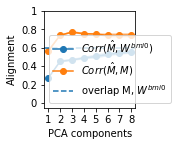

In [26]:
""" Vary Alignment between Wbmi0 and Wbmi1 """
paper = True
save = True

    

fig,ax=plt.subplots()
n_samples = np.asarray(corr_dict['angle1']).shape[0]
mn1 = np.mean(np.asarray(corr_dict['angle1']),axis=0)
mn2 = np.mean(np.asarray(corr_dict['angle2']),axis=0)
std1 = np.std(np.asarray(corr_dict['angle1']),axis=0)
std2 = np.std(np.asarray(corr_dict['angle2']),axis=0)
sem1 = std1/np.sqrt(n_samples)
sem2 = std2/np.sqrt(n_samples)

# plt.plot(train_durations,mn1,'o-',label=r'$Corr(\hat{M},W^{bmi0})$')
# plt.fill_between(train_durations,mn1-sem1,mn1+sem1,alpha=0.5)
# plt.plot(train_durations,mn2,'o-',label=r'$Corr(\hat{M},M)$')
# plt.fill_between(train_durations,mn2-sem2,mn2+sem2,alpha=0.5)
# plt.xlabel('training_duration')

# plt.plot(sig_rec_noise,mn1,'o-',label=r'$Corr(\hat{M},W^{bmi0})$')
# plt.fill_between(sig_rec_noise,mn1-sem1,mn1+sem1,alpha=0.5)
# plt.plot(sig_rec_noise,mn2,'o-',label=r'$Corr(\hat{M},M)$')
# plt.fill_between(sig_rec_noise,mn2-sem2,mn2+sem2,alpha=0.5)
# plt.xlabel('sig_rec noise')

# plt.plot(test_durations,mn1,'o-',label=r'$Corr(\hat{M},W^{bmi0})$')
# plt.fill_between(test_durations,mn1-sem1,mn1+sem1,alpha=0.5)
# plt.plot(test_durations,mn2,'o-',label=r'$Corr(\hat{M},M)$')
# plt.fill_between(test_durations,mn2-sem2,mn2+sem2,alpha=0.5)
# plt.xlabel('test_duration')

plt.plot(pca_components,mn1,'o-',label=r'$Corr(\hat{M},W^{bmi0})$')
plt.fill_between(pca_components,mn1-sem1,mn1+sem1,alpha=0.5)
plt.plot(pca_components,mn2,'o-',label=r'$Corr(\hat{M},M)$')
plt.fill_between(pca_components,mn2-sem2,mn2+sem2,alpha=0.5)
plt.xlabel('PCA components')

plt.axhline(y=overlap,linestyle='--',label='overlap M, '+r'$W^{bmi0}$')


plt.ylabel('Alignment')
plt.ylim([0,1])
plt.legend()

if paper:
    fig,ax = paper_format(fig=fig,ax=ax,xlabels=[1,2,3,4,5,6,7,8],ylabels=[0,0.2,0.4,0.6,0.8,1],linewidth=2,ylim=[-0.05,1],figsize=(2.25,2.25))

plt.show()

if save:
    fig.savefig(folder+'PCA-estimate-Mhat-v3.pdf')

I think tracking PCs is the most interesting way to trackthe estimate of M

# Part 2 - Estimating Mhat with RFLO

In [4]:
trial_duration = 20
n_in=4
frac_on = 1

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

1it [00:00,  8.44it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.2
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
g_in: 2.0
g_rec: 0.1
g_out: 2.0
g_fb: 2
driving_feedback: True
eta_fb: 0.1
sig_fb: 0.01
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fea26f2b750>
M norm: 1.32	 M angle: 0.81, 13 iterations

2500it [00:27, 92.97it/s]


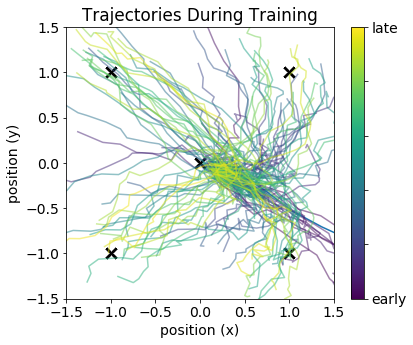

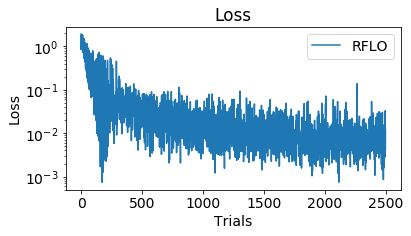

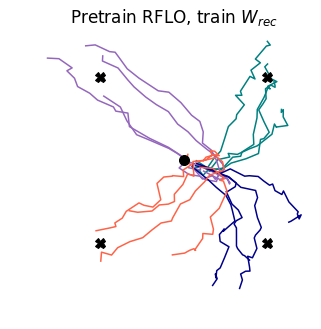

In [5]:
rnn_seed = 72
scale=5
pretrain_duration = 2500
overlap_w_m = 0.8
n_change_w_m = 15

# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,eta_fb=0.1,g_fb=2,g_rec=0.1,
               sig_in=0.0,sig_rec=0.2,sig_out=0.01,sig_fb=0.01,
               velocity_transform=False, tau_vel = 0.8, dt_vel = 0.1,
               driving_feedback=True,
               rng=np.random.RandomState(rnn_seed))
params.print_params()



# Initialize RNN
net0 = RNN(params)
w_m = choose_aligned_matrix(net0.w_out.T,n_change=n_change_w_m,overlap=overlap_w_m,rng=np.random.RandomState(56),zero=False,tolerance=0.01,loop=1000)

""" set M and Wfb to be equal """
net0.set_weights(w_m = w_m, w_fb = scale*w_m)

sim0 = Simulation(net0)
rflo = RFLO(net0,apply_to=['w_rec'],online=False)
sim0.run_session(n_trials=pretrain_duration, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['loss','h'], plot=True, plot_freq=20)

fig0 = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4],title='Pretrain RFLO, train '+r'$W_{rec}$')








500it [00:04, 103.51it/s]


(20, 50)
n_samples,n_features:  (10000, 50)
C:  (10, 50)


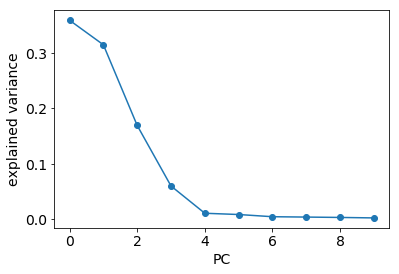

In [6]:
""" Apply PCA to static activity, Estimate Mhat """
net0_post = RNN(params)
net0_post.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy(),w_fb = net0.w_fb.copy(),w_m = net0.w_m.copy())
sim0_post = Simulation(net0_post)
trackvars = TrackVars(net0_post,apply_to=[]) 
sim0_post.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err','pos'], plot=False, plot_freq=10)

# concatenate data
activity = sim0_post.session_probes['h'][0].squeeze()
print(activity.shape)

for i in range(1,len(sim0_post.session_probes['h'])):
    activity = np.vstack((activity,sim0_post.session_probes['h'][i].squeeze()))
    
print('n_samples,n_features: ',activity.shape)

""" Apply PCA """
pca = PCA(n_components=10)
pca.fit(activity)
C = pca.components_

print('C: ',pca.components_.shape)
fig,ax = plt.subplots()
#plt.plot(pca.explained_variance_/np.sum(pca.explained_variance_),'o-') # same dealio
plt.plot(pca.explained_variance_ratio_,'o-')
plt.ylabel('explained variance')
plt.xlabel('PC')
plt.show()

In [7]:



""" Compare with cursor location """
pos = sim0_post.session_probes['pos'][0].squeeze()
print(pos.shape)

for i in range(1,len(sim0_post.session_probes['pos'])):
    pos = np.vstack((pos,sim0_post.session_probes['pos'][i].squeeze()))
print(pos.shape)

lr = LinearRegression(fit_intercept=False)
lr.fit((C @ activity.T).T, pos)
D = lr.coef_

print(D.shape)

Mhat = (D@C).T


# confirm overlap between w_out and w_m
_, angle = return_norm_and_angle(net0.w_m,Mhat)
print('\n w_m vs. Mhat angle: {:.2f}'.format(angle))

_, angle = return_norm_and_angle(net0.w_out,net0.w_fb.T)
print('\n w_fb vs. w_out angle: {:.2f}'.format(angle))

_, angle = return_norm_and_angle(net0.w_m,net0.w_fb)
print('\n w_m vs. w_fb angle: {:.2f}'.format(angle))

_, angle = return_norm_and_angle(net0.w_m,net0.w_out.T)
print('\n w_m vs. w_out angle: {:.2f}'.format(angle))
        
_, angle = return_norm_and_angle(net0.w_out,Mhat.T)
print('\n w_out vs. Mhat angle: {:.2f}'.format(angle))

(20, 2)
(10000, 2)
(2, 10)

 w_m vs. Mhat angle: 0.73

 w_fb vs. w_out angle: 0.81

 w_m vs. w_fb angle: 1.00

 w_m vs. w_out angle: 0.81

 w_out vs. Mhat angle: 0.72


In [34]:
np.asarray([lr.intercept_]* 3).shape

(3, 2)

4it [00:00, 38.82it/s]

M norm: 2.08	 M angle: 0.40, 69 iterations
w_out1 norm: 1.56	 w_out vs. w_out1 angle: 0.48
w_m norm: 2.08	 w_out1 vs. w_m angle: 0.40
w_m norm: 1.32	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.47	 w_out1 vs. Mhat angle: 0.33

500it [00:04, 114.06it/s]
1000it [00:10, 91.49it/s]
500it [00:04, 115.55it/s]


AR early fit 0.977, late fit 0.977


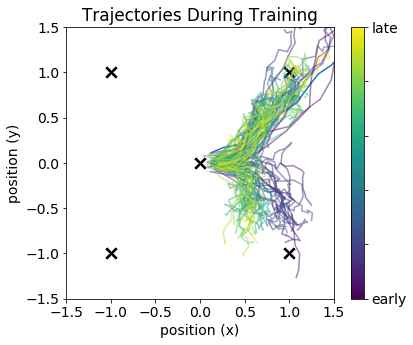

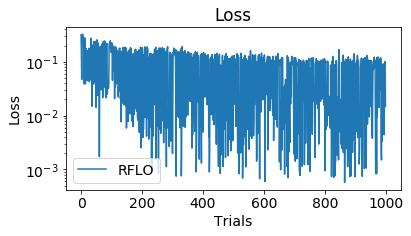

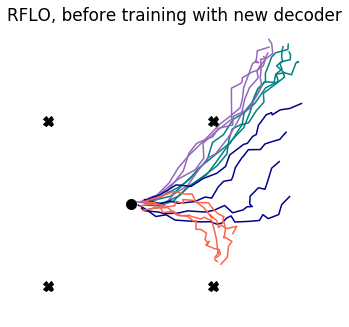

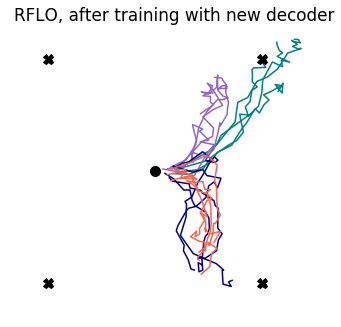

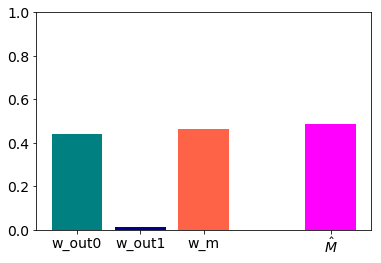

11it [00:00, 107.94it/s]

M norm: 1.98	 M angle: 0.49, 4 iterations
w_out1 norm: 1.70	 w_out vs. w_out1 angle: 0.43
w_m norm: 1.98	 w_out1 vs. w_m angle: 0.49
w_m norm: 1.32	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.74	 w_out1 vs. Mhat angle: 0.19

500it [00:04, 108.19it/s]
1000it [00:12, 81.68it/s]
500it [00:04, 110.00it/s]


AR early fit 0.973, late fit 0.980


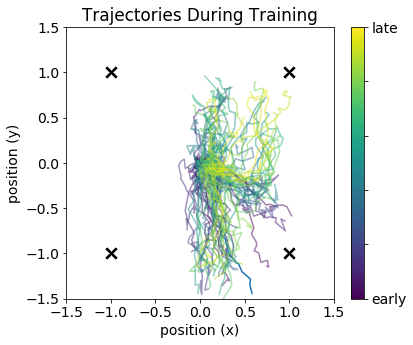

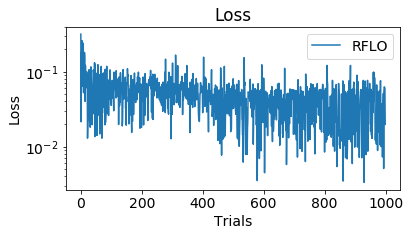

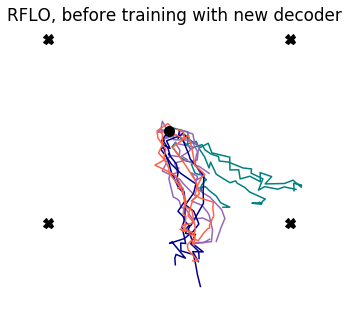

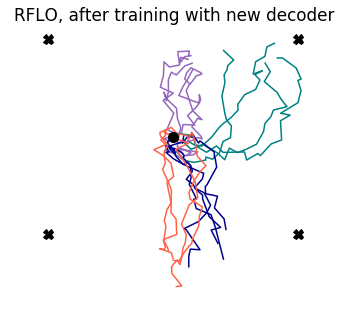

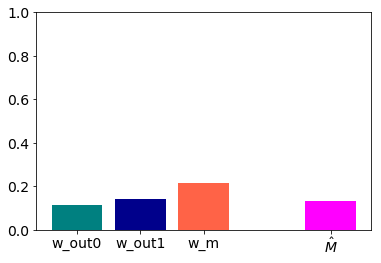

10it [00:00, 94.25it/s]

M norm: 1.80	 M angle: 0.60, 10 iterations
w_out1 norm: 1.68	 w_out vs. w_out1 angle: 0.48
w_m norm: 1.80	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.32	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.49	 w_out1 vs. Mhat angle: 0.47

500it [00:04, 107.72it/s]
1000it [00:11, 88.14it/s]
500it [00:04, 114.63it/s]


AR early fit 0.979, late fit 0.980


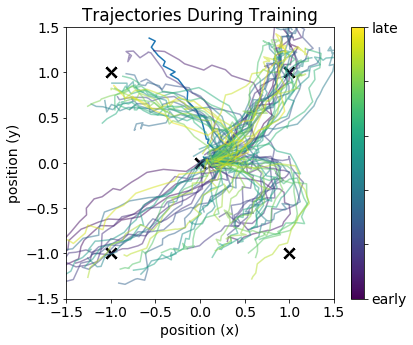

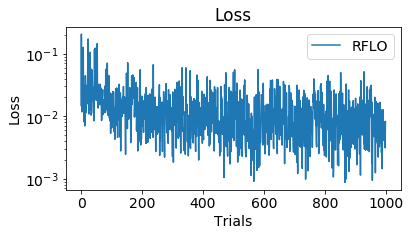

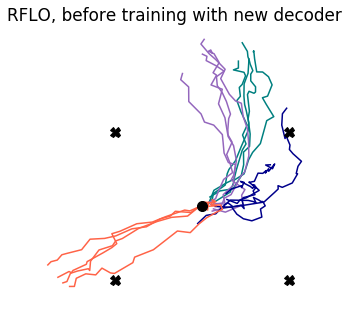

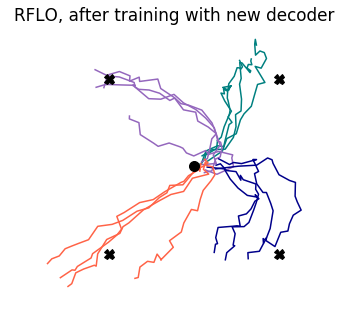

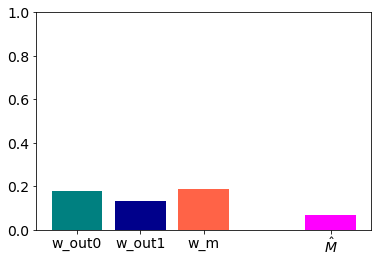

11it [00:00, 102.35it/s]

M norm: 1.34	 M angle: 0.80, 22 iterations
w_out1 norm: 1.44	 w_out vs. w_out1 angle: 0.69
w_m norm: 1.34	 w_out1 vs. w_m angle: 0.80
w_m norm: 1.32	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.52	 w_out1 vs. Mhat angle: 0.62

500it [00:04, 103.15it/s]
1000it [00:11, 87.91it/s]
500it [00:04, 111.95it/s]


AR early fit 0.977, late fit 0.976


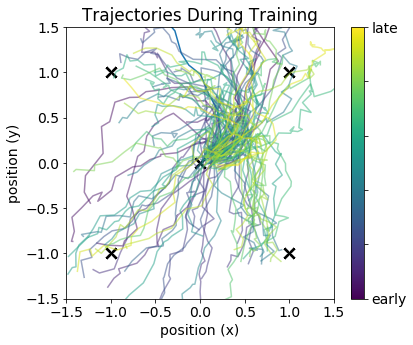

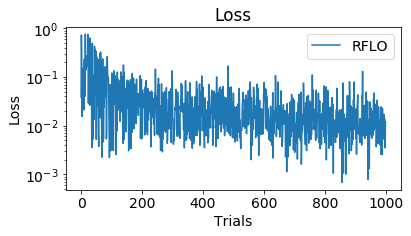

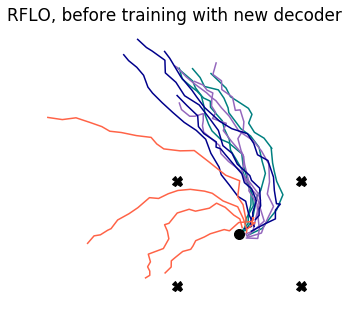

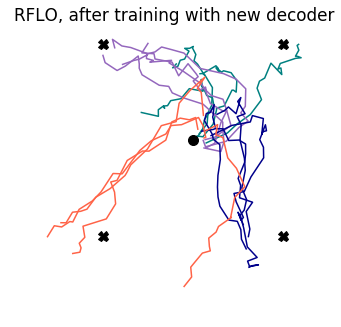

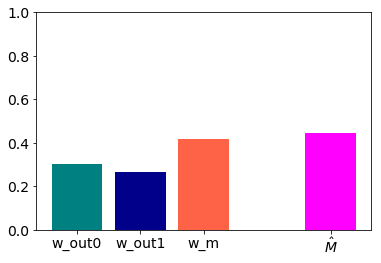

8it [00:00, 74.56it/s]

M norm: 2.09	 M angle: 0.39, 49 iterations
w_out1 norm: 1.71	 w_out vs. w_out1 angle: 0.37
w_m norm: 2.09	 w_out1 vs. w_m angle: 0.39
w_m norm: 1.32	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.53	 w_out1 vs. Mhat angle: 0.28

500it [00:04, 104.77it/s]
1000it [00:11, 84.03it/s]
500it [00:04, 115.57it/s]


AR early fit 0.978, late fit 0.981


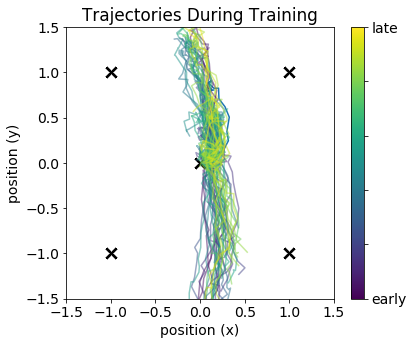

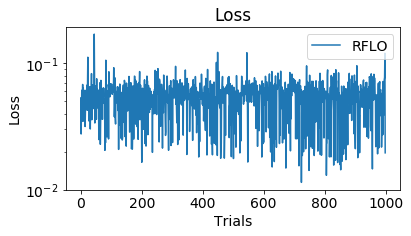

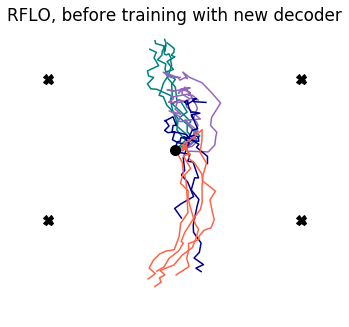

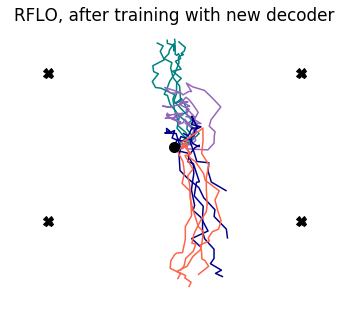

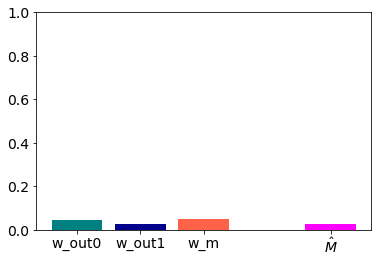

10it [00:00, 99.24it/s]

M norm: 1.94	 M angle: 0.50, 25 iterations
w_out1 norm: 1.55	 w_out vs. w_out1 angle: 0.49
w_m norm: 1.94	 w_out1 vs. w_m angle: 0.50
w_m norm: 1.32	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.34	 w_out1 vs. Mhat angle: 0.46

500it [00:04, 116.67it/s]
1000it [00:11, 90.38it/s]
500it [00:04, 116.80it/s]


AR early fit 0.975, late fit 0.980


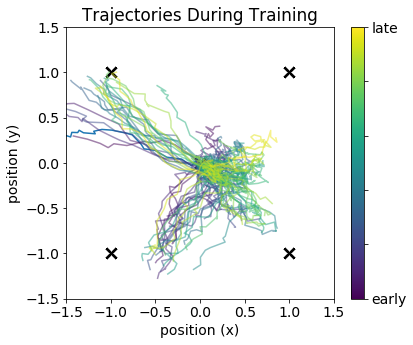

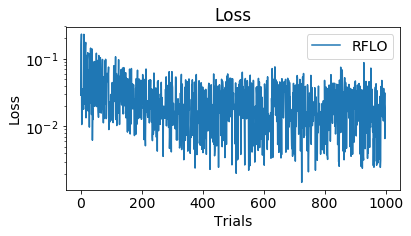

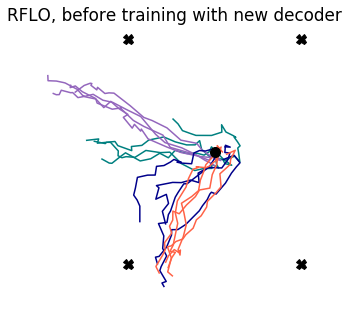

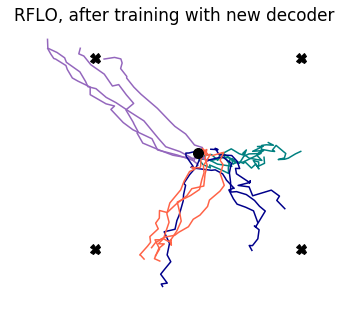

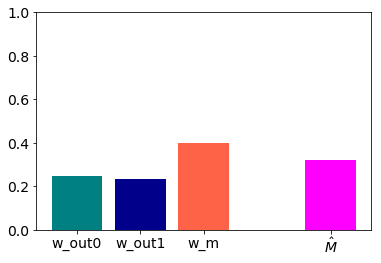

11it [00:00, 105.23it/s]

M norm: 1.81	 M angle: 0.59, 0 iterations
w_out1 norm: 1.51	 w_out vs. w_out1 angle: 0.57
w_m norm: 1.81	 w_out1 vs. w_m angle: 0.59
w_m norm: 1.32	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.61	 w_out1 vs. Mhat angle: 0.36

500it [00:04, 109.56it/s]
1000it [00:10, 91.50it/s]
500it [00:04, 116.21it/s]


AR early fit 0.978, late fit 0.981


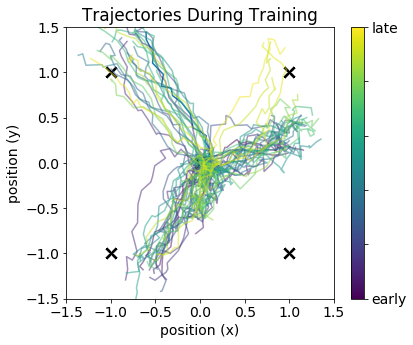

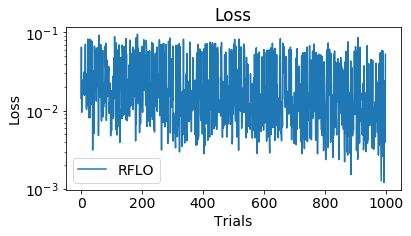

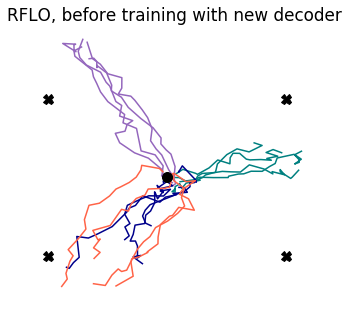

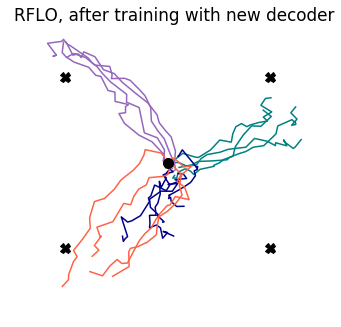

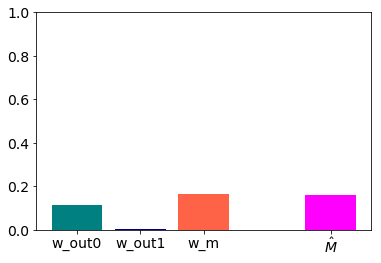

11it [00:00, 102.63it/s]

M norm: 1.36	 M angle: 0.79, 7 iterations
w_out1 norm: 1.52	 w_out vs. w_out1 angle: 0.65
w_m norm: 1.36	 w_out1 vs. w_m angle: 0.79
w_m norm: 1.32	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.57	 w_out1 vs. Mhat angle: 0.59

500it [00:04, 104.80it/s]
1000it [00:11, 85.17it/s]
500it [00:04, 105.32it/s]


AR early fit 0.978, late fit 0.978


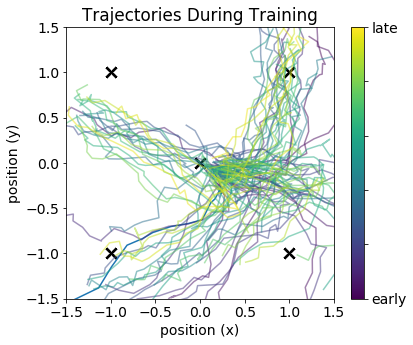

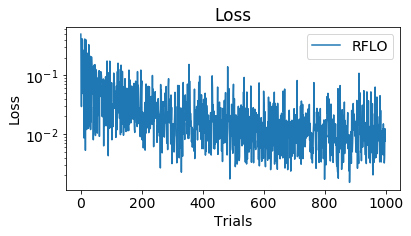

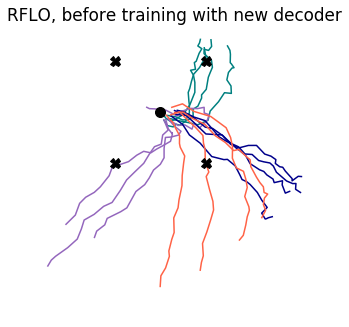

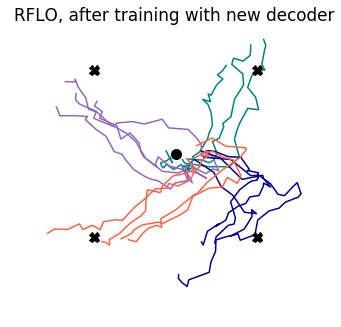

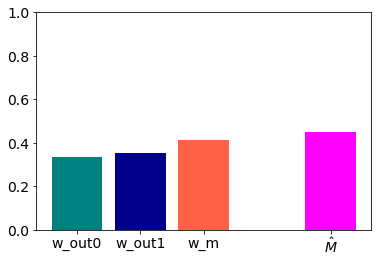

8it [00:00, 73.85it/s]

M norm: 2.08	 M angle: 0.40, 124 iterations
w_out1 norm: 1.69	 w_out vs. w_out1 angle: 0.37
w_m norm: 2.08	 w_out1 vs. w_m angle: 0.40
w_m norm: 1.32	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.48	 w_out1 vs. Mhat angle: 0.30

500it [00:05, 93.66it/s]
1000it [00:12, 79.00it/s]
500it [00:04, 113.85it/s]


AR early fit 0.977, late fit 0.979


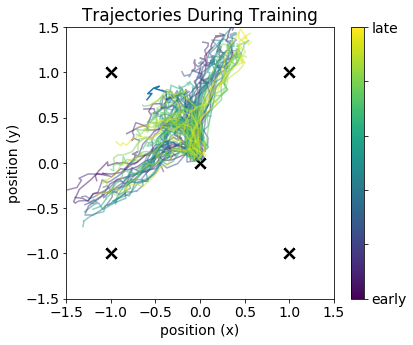

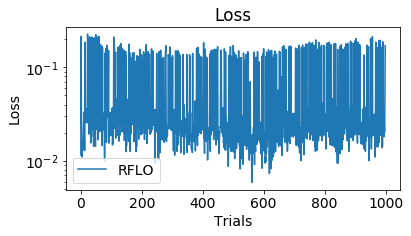

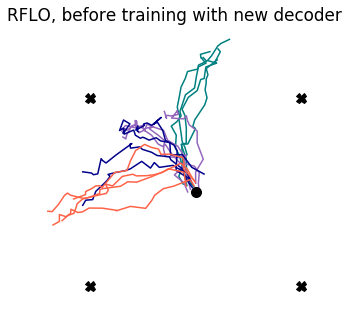

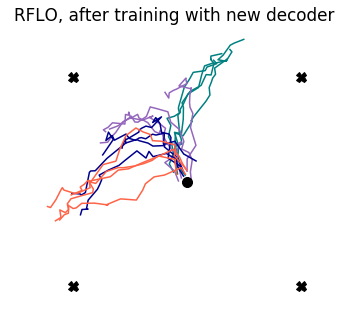

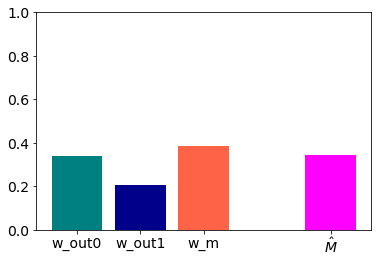

11it [00:00, 104.52it/s]

M norm: 1.93	 M angle: 0.51, 7 iterations
w_out1 norm: 1.46	 w_out vs. w_out1 angle: 0.56
w_m norm: 1.93	 w_out1 vs. w_m angle: 0.51
w_m norm: 1.32	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.32	 w_out1 vs. Mhat angle: 0.49

500it [00:05, 97.83it/s] 
1000it [00:11, 90.33it/s]
500it [00:05, 88.58it/s]


AR early fit 0.977, late fit 0.981


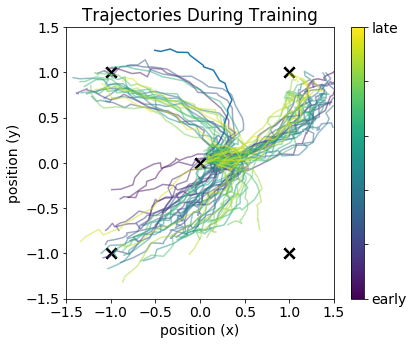

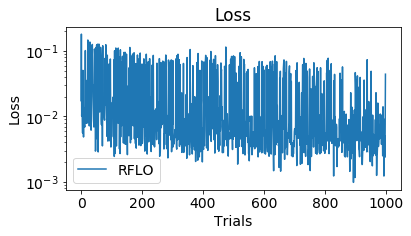

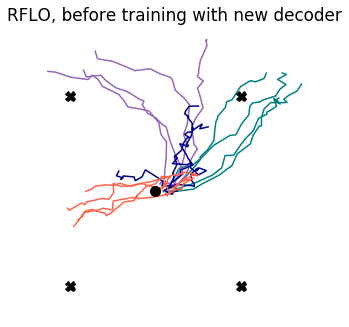

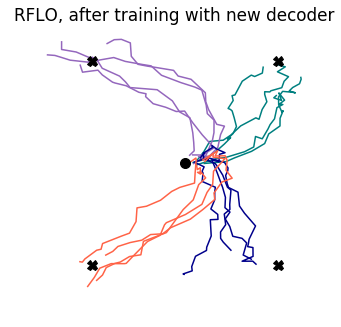

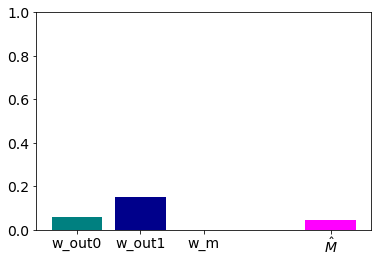

9it [00:00, 82.15it/s]

M norm: 1.77	 M angle: 0.61, 0 iterations
w_out1 norm: 1.52	 w_out vs. w_out1 angle: 0.55
w_m norm: 1.77	 w_out1 vs. w_m angle: 0.61
w_m norm: 1.32	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.53	 w_out1 vs. Mhat angle: 0.38

500it [00:05, 99.65it/s] 
1000it [00:12, 82.76it/s]
500it [00:05, 87.07it/s] 


AR early fit 0.979, late fit 0.978


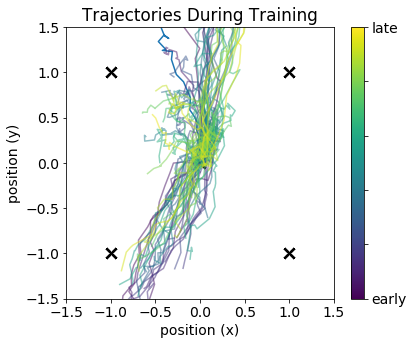

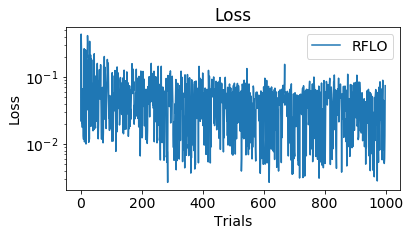

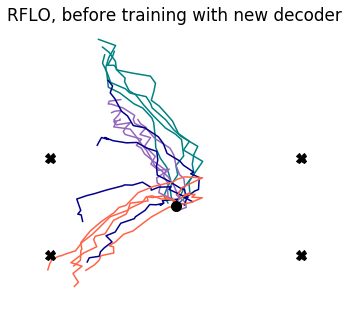

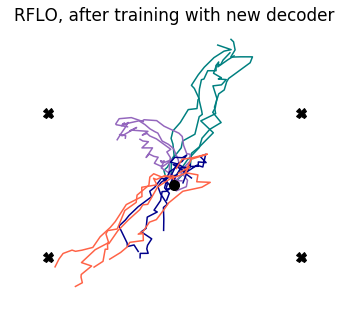

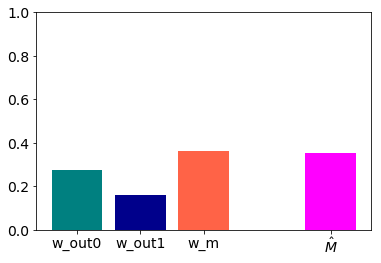

6it [00:00, 55.69it/s]

M norm: 1.31	 M angle: 0.81, 0 iterations
w_out1 norm: 1.07	 w_out vs. w_out1 angle: 0.80
w_m norm: 1.31	 w_out1 vs. w_m angle: 0.81
w_m norm: 1.32	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.43	 w_out1 vs. Mhat angle: 0.58

500it [00:04, 110.03it/s]
1000it [00:13, 75.55it/s]
500it [00:04, 95.98it/s]


AR early fit 0.979, late fit 0.978


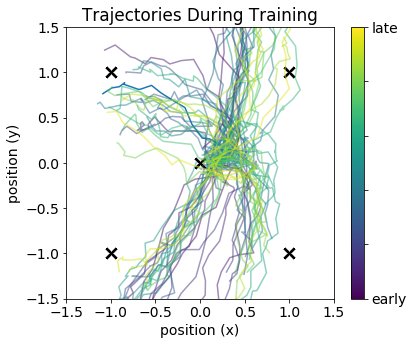

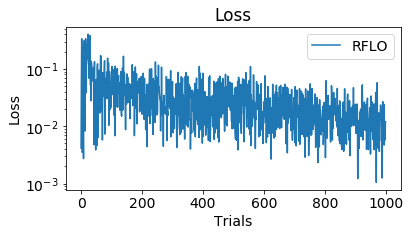

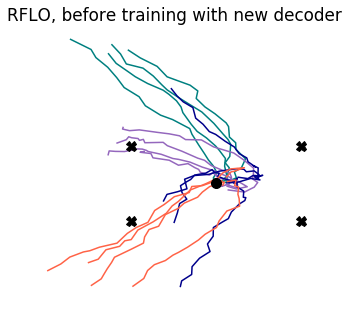

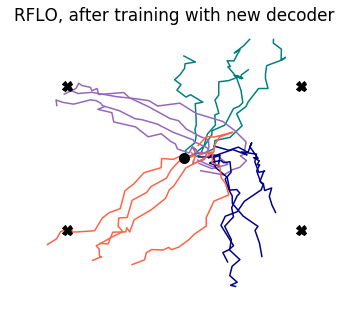

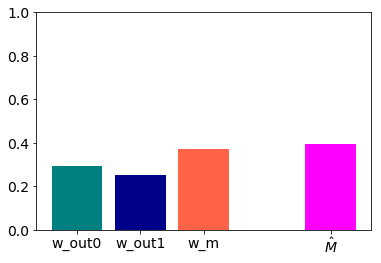

In [8]:



""" Average over multiple seeds """
#seeds = [52,47,667] #,1,12,54,72,81]
seeds = [0,1,3]#22,33,47]
overlaps = [0.4,0.5,0.6,0.8]
n_changes = [60,60,50,20]

train_duration = 1000
test_duration = 500

stats = {}
stats['corr1'] = []
stats['corr2'] = []
stats['corr3'] = []
stats['corr4'] = []
stats['corrcoef'] = []

stats['seeds'] = seeds
stats['overlaps'] = overlaps
stats['n_changes'] = n_changes
stats['scale_w_fb'] = scale
stats['train_duration'] = train_duration
stats['frac_on'] = frac_on
stats['RNNparams'] = params

for seed in seeds:

    corr1_list = []
    corr2_list = []
    corr3_list = []
    corr4_list = []
    corrcoef_list = []


    for overlap,n_change in zip(overlaps,n_changes):
        
        # OPTION 1 - ALIGNMENT BETWEEN WBMI0 AND WBMI1
        #w_out1 = choose_aligned_matrix(net0.w_out.copy(),n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)
        
        # OPTION 2 - ALIGNMENT BETWEEN M AND WBMI1
        w_out1 = choose_aligned_matrix(net0.w_m.copy().T,n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)

        # OPTION 3 - ALIGNMENT BETWEEN M AND Mhat. Not great
        #w_out1 = choose_aligned_matrix(Mhat.T,n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)

        
        # confirm overlap between w_out1 and w_out
        norm, angle = return_norm_and_angle(net0.w_out,w_out1)
        print('\nw_out1 norm: {:.2f}'.format(norm) + '\t w_out vs. w_out1 angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out1 and w_m
        norm, angle = return_norm_and_angle(w_out1,w_m.T)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out1 vs. w_m angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out and w_m
        norm, angle = return_norm_and_angle(net0.w_out,w_m.T)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out vs. w_m angle: {:.2f}'.format(angle),end='')
        
        # confirm overlap between w_out and w_m
        norm, angle = return_norm_and_angle(w_out1,Mhat.T)
        print('\nw_out1 norm: {:.2f}'.format(norm) + '\t w_out1 vs. Mhat angle: {:.2f}'.format(angle),end='')
        
        
        
        
        net1_pre = RNN(params)
        net1_pre.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy(), w_fb = net0.w_fb.copy())
        net1_pre.set_weights(w_out = w_out1)
        net1_pre.set_weights(w_m = net0.w_m.copy()) # still use true w_m

        # unfortunately I need to make a different network to maintain integrity of pre and post simulations for plotting
        net1 = RNN(params)
        net1.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy(), w_fb = net0.w_fb.copy())
        net1.set_weights(w_out = w_out1)
        net1.set_weights(w_m = net0.w_m.copy()) # still use true w_m




        """ Track activity with new decoder, before training """

        sim1_pre = Simulation(net1_pre)
        trackvars = TrackVars(net1_pre,apply_to=[]) 
        sim1_pre.run_session(n_trials=test_duration, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)
        #fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

        """ Train with new decoder """

        sim1_train = Simulation(net1)
        rflo = RFLO(net1,apply_to=['w_rec'],online=False)
        sim1_train.run_session(n_trials=train_duration, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','loss','err'], plot=True, plot_freq=10)

        """ Track activity with new decoder, after training """
        net1_post = RNN(params)
        net1_post.set_weights(w_in=net1.w_in.copy(), w_rec=net1.w_rec.copy(), w_fb = net1.w_fb.copy())
        net1_post.set_weights(w_out = net1.w_out.copy())
        net1_post.set_weights(w_m = net1.w_m.copy())

        sim1_post = Simulation(net1_post)
        trackvars = TrackVars(net1_post,apply_to=[]) 
        sim1_post.run_session(n_trials=test_duration, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)

        
        fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

        fig = plot_trained_trajectories(sim=sim1_post, tasks=[task1,task2,task3,task4],title='RFLO, after training with new decoder')
        
        
        """ Calculate F fields """
        F_early, score_early = flow_field_data(sim1_pre.session_probes['h'])
        F_late, score_late = flow_field_data(sim1_post.session_probes['h'])

        print('AR early fit {:.3f}, late fit {:.3f}'.format(score_early,score_late))

        Fdata = F_late - F_early

        # separate train and test data from sim1_train
        n_total = len(sim1_train.session_probes['h'])
        n_train = int(0.5 * n_total)
        idx_train = np.random.RandomState(1975+seed).choice(np.arange(0,n_total),size=n_train,replace=False).astype(int)
        idx_test = np.arange(0,n_total)[~idx_train].astype(int)
        #idx_test=idx_train

        h_train = np.asarray(sim1_train.session_probes['h'])[idx_train,:,:,:]
        err_train = np.asarray(sim1_train.session_probes['err'])[idx_train,:,:,:]

        Fpred_w_out = flow_field_predicted(net0.w_out,err_train,h_train)
        Fpred_w_out1 = flow_field_predicted(w_out1,err_train,h_train)
        Fpred_w_m = flow_field_predicted(net1.w_m.T,err_train,h_train) # NOTE Mhat is USED HERE TO PREDICT
        Fpred_w_Mhat = flow_field_predicted(Mhat.T,err_train,h_train) # NOTE Mhat is USED HERE TO PREDICT

        h_test = np.asarray(sim1_train.session_probes['h'])[idx_test,:,:,:]

        corr1 = calculate_flow_field_correlation(Fpred_w_out,Fdata,h_test) # could also sample sim_test
        corr1_list.append(corr1)

        corr2 = calculate_flow_field_correlation(Fpred_w_out1,Fdata,h_test) # could also sample sim_test
        corr2_list.append(corr2)

        corr3 = calculate_flow_field_correlation(Fpred_w_m,Fdata,h_test) # could also sample sim_test
        corr3_list.append(corr3)
        
        corr4 = calculate_flow_field_correlation(Fpred_w_Mhat,Fdata,h_test) # could also sample sim_test
        corr4_list.append(corr4)
        
        fig,ax = plt.subplots(1,1)
        plt.bar([0,1,2,4],[corr1,corr2,corr3,corr4],tick_label=['w_out0','w_out1','w_m',r'$\hat{M}$'],color=['teal','darkblue','tomato','magenta'])
        plt.ylim([0,1])
        plt.show()
        
        
        
        
        
        
      
        
    # update
    stats['corr1'].append(corr1_list)
    stats['corr2'].append(corr2_list)
    stats['corr3'].append(corr3_list)
    stats['corr4'].append(corr4_list)
    #stats['corrcoef'].append(corrcoef_list)



In [12]:
# confirm overlap between w_out and w_m
_, angle = return_norm_and_angle(net0.w_m,Mhat)
print('\nw_m vs. Mhat angle: {:.2f}'.format(angle),end='')
        



w_m vs. Mhat angle: 0.78

In [51]:
stats_rflo_mhat = stats
stats_rflo_mhat['params']=params

""" save stats """
save = True
tag = 'fig4-5-18-v3'

if save:
    
    with open(folder+'stats_rflo_mhat-'+tag+'.pickle', 'wb') as handle:
        pickle.dump(stats_rflo_mhat, handle, protocol=pickle.HIGHEST_PROTOCOL)



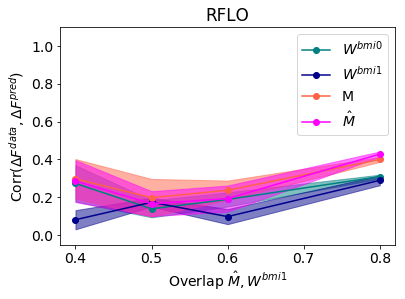

In [9]:
""" Plot scaling of W_fb"""

save = False
paper = False

x = overlaps
n_samples = np.asarray(stats['corr1']).shape[0]
mn1 = np.mean(np.asarray(stats['corr1']).T,axis=1)
mn2 = np.mean(np.asarray(stats['corr2']).T,axis=1)
mn3 = np.mean(np.asarray(stats['corr3']).T,axis=1)
mn4 = np.mean(np.asarray(stats['corr4']).T,axis=1)
std1 = np.std(np.asarray(stats['corr1']).T,axis=1)
std2 = np.std(np.asarray(stats['corr2']).T,axis=1)
std3 = np.std(np.asarray(stats['corr3']).T,axis=1)
std4 = np.std(np.asarray(stats['corr4']).T,axis=1)
sem1 = std1/np.sqrt(n_samples)
sem2 = std2/np.sqrt(n_samples)
sem3 = std3/np.sqrt(n_samples)
sem4 = std4/np.sqrt(n_samples)

fig,ax = plt.subplots(1,1)


plt.plot(x,mn1,'o-',color='teal',label=r'$W^{bmi0}$')
plt.plot(x,mn2,'o-',color='darkblue',label=r'$W^{bmi1}$')
plt.plot(x,mn3,'o-',color='tomato',label='M')
plt.plot(x,mn4,'o-',color='magenta',label=r'$\hat{M}$')
plt.fill_between(x,mn1-sem1,mn1+sem1,alpha=0.5,color='teal')
plt.fill_between(x,mn2-sem2,mn2+sem2,alpha=0.5,color='darkblue')
plt.fill_between(x,mn3-sem3,mn3+sem3,alpha=0.5,color='tomato')
plt.fill_between(x,mn4-sem4,mn4+sem4,alpha=0.5,color='magenta')



plt.title('RFLO')
plt.ylabel('Corr('+r'$\Delta F^{data},\Delta F^{pred})$')
plt.xlabel('Overlap '+r'$\hat{M},W^{bmi1}$')
plt.ylim([-0.05,1.1])
#plt.xlim([-50,1400])
plt.legend()

if paper:
    fig,ax = paper_format(fig=fig,ax=ax,xlabels=None,ylabels=[0,0.2,0.4,0.6,0.8,1],linewidth=2,ylim=[-0.05,0.6],figsize=(2.25,2.5))

plt.show()

if save:
    fig.savefig(folder+'rflo-Mhat-v2.pdf')

In [3]:
pwd

'/Users/jacobportes/Documents/Code/rnn-learning/experiments/NeurIPS-2022-5-16'

# REINFORCE, Estimate Mhat

In the following code block, we do the following:

5it [00:00, 48.62it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.2
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.2
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2
driving_feedback: True
eta_fb: 0.1
sig_fb: 0.01
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fd3d5f3f900>
M norm: 1.15	 M angle: 0.81, 25 iterations

5000it [01:22, 60.35it/s]
500it [00:07, 64.73it/s]


(20, 50)
n_samples,n_features:  (10000, 50)
C:  (10, 50)


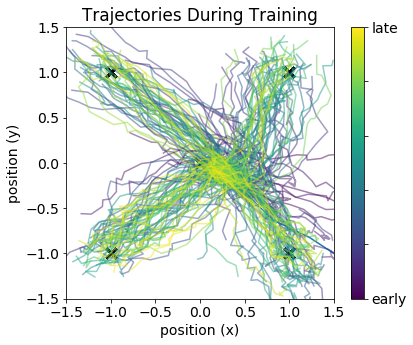

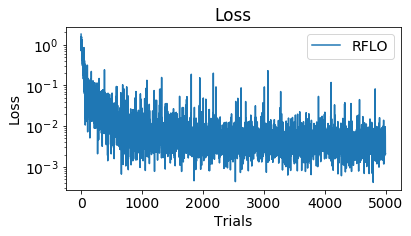

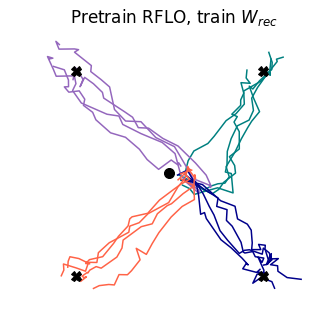

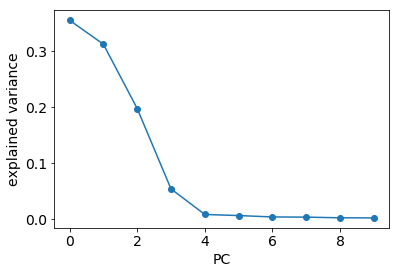

12it [00:00, 52.71it/s]

(20, 2)
(10000, 2)
(2, 10)
M norm: 1.75	 M angle: 0.21, 34 iterations
w_out1 norm: 1.75	 w_out vs. w_out1 angle: 0.21
w_m norm: 2.03	 w_out1 vs. w_m angle: 0.16
w_m norm: 1.15	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.36	 w_out1 vs. Mhat angle: 0.14

500it [00:08, 62.41it/s]
10000it [03:51, 43.12it/s]
500it [00:08, 54.69it/s]


AR early fit 0.975, late fit 0.976


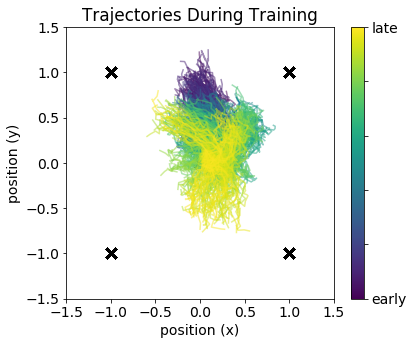

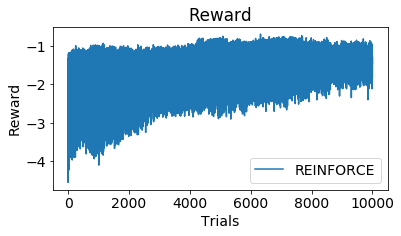

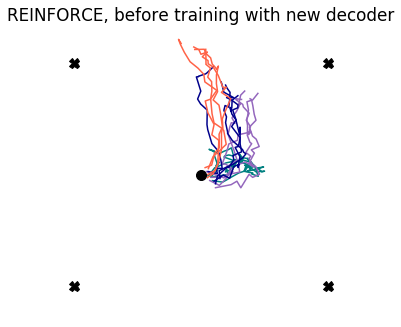

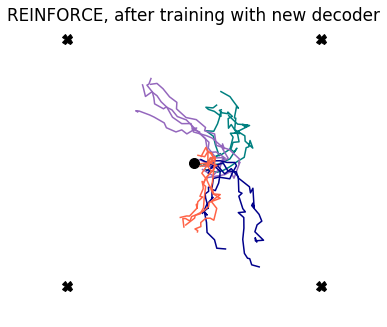

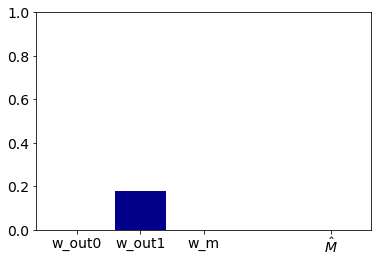

0it [00:00, ?it/s]

M norm: 1.60	 M angle: 0.41, 98 iterations
w_out1 norm: 1.60	 w_out vs. w_out1 angle: 0.41
w_m norm: 1.91	 w_out1 vs. w_m angle: 0.33
w_m norm: 1.15	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.43	 w_out1 vs. Mhat angle: 0.20

500it [00:10, 49.47it/s]
10000it [03:33, 46.81it/s]
500it [00:05, 84.80it/s]


AR early fit 0.976, late fit 0.979


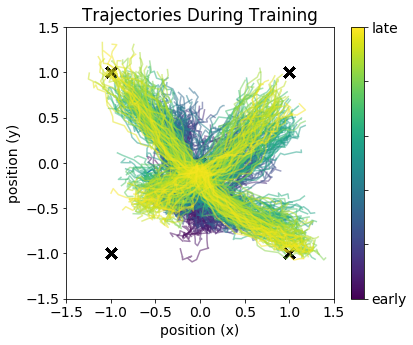

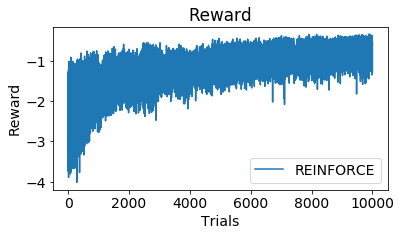

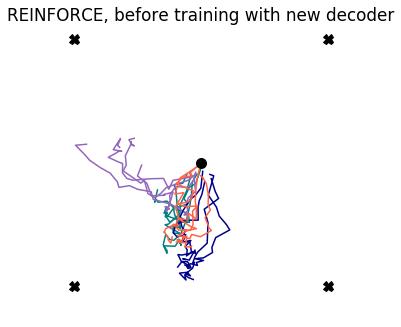

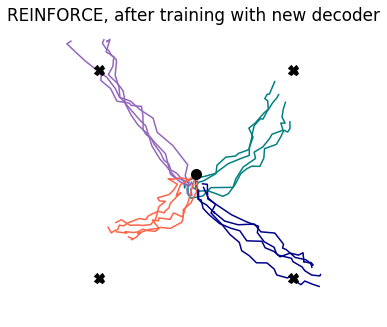

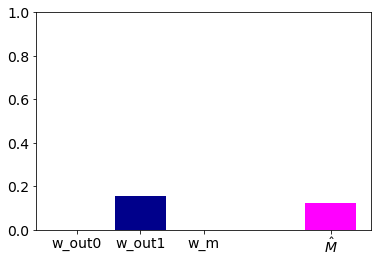

9it [00:00, 80.28it/s]

M norm: 1.37	 M angle: 0.60, 6 iterations
w_out1 norm: 1.37	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.81	 w_out1 vs. w_m angle: 0.43
w_m norm: 1.15	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.32	 w_out1 vs. Mhat angle: 0.38

500it [00:05, 85.23it/s]
10000it [03:09, 52.79it/s]
500it [00:07, 70.89it/s]


AR early fit 0.974, late fit 0.981


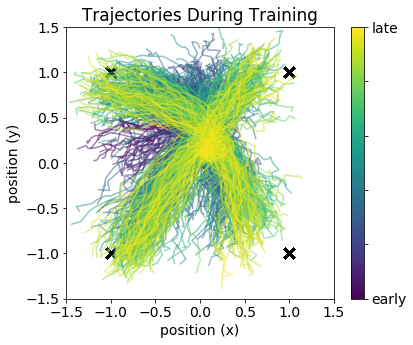

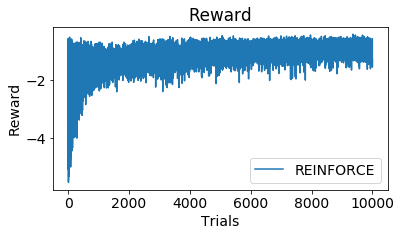

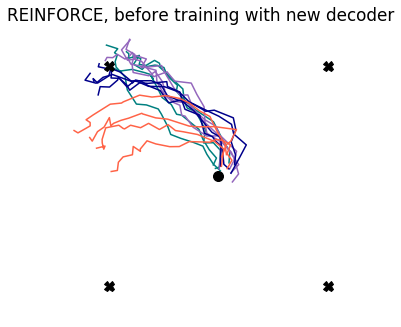

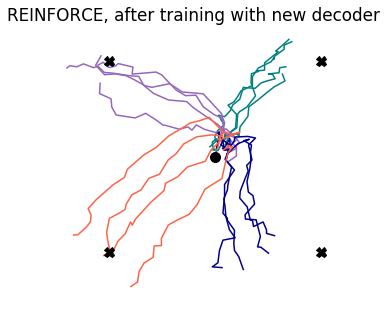

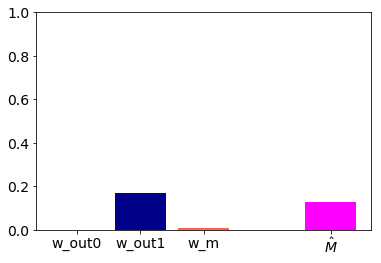

NO OVERLAP M angle: 0.90, 516 iterations

8it [00:00, 72.45it/s]

M norm: 1.00	 M angle: 0.81, 619 iterations
w_out1 norm: 1.00	 w_out vs. w_out1 angle: 0.81
w_m norm: 1.51	 w_out1 vs. w_m angle: 0.64
w_m norm: 1.15	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.38	 w_out1 vs. Mhat angle: 0.47

500it [00:07, 69.55it/s]
10000it [03:15, 51.05it/s]
500it [00:06, 71.44it/s]


AR early fit 0.979, late fit 0.983


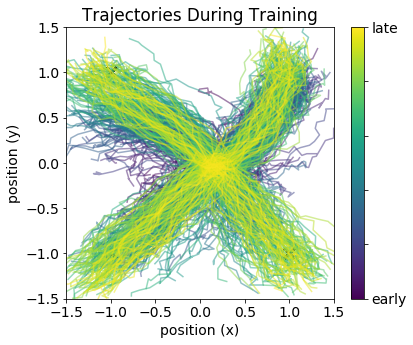

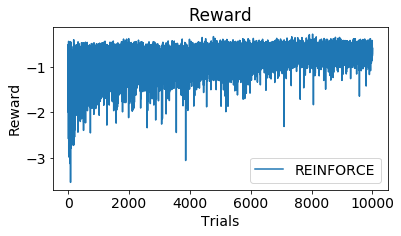

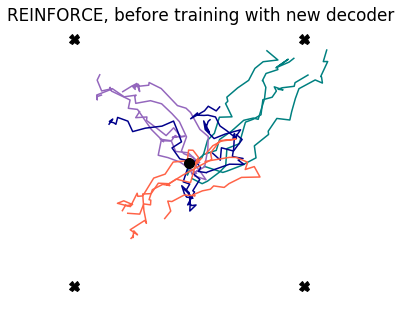

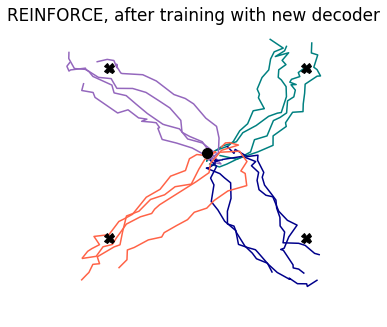

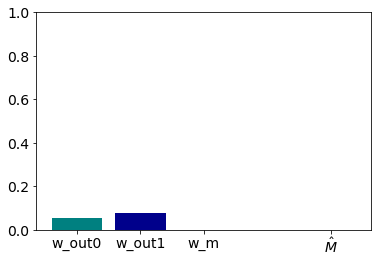

7it [00:00, 68.79it/s]

M norm: 1.75	 M angle: 0.20, 25 iterations
w_out1 norm: 1.75	 w_out vs. w_out1 angle: 0.20
w_m norm: 2.05	 w_out1 vs. w_m angle: 0.12
w_m norm: 1.15	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.31	 w_out1 vs. Mhat angle: 0.18

500it [00:07, 68.97it/s]
10000it [03:36, 46.12it/s]
500it [00:07, 65.08it/s]


AR early fit 0.973, late fit 0.979


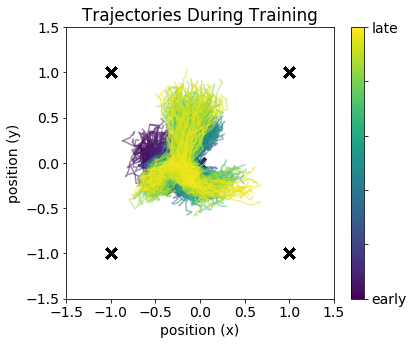

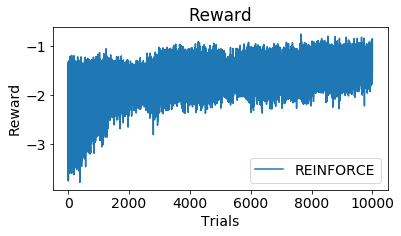

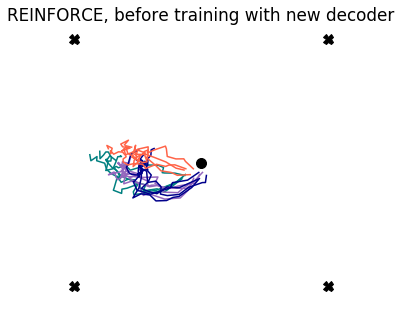

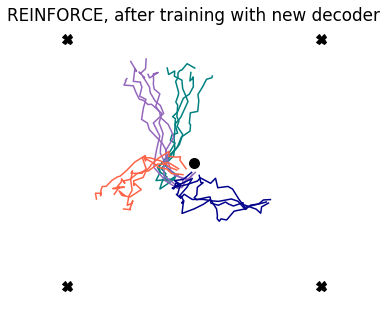

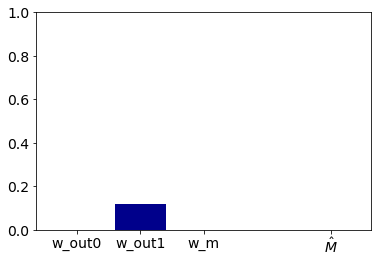

7it [00:00, 67.52it/s]

M norm: 1.61	 M angle: 0.39, 116 iterations
w_out1 norm: 1.61	 w_out vs. w_out1 angle: 0.39
w_m norm: 1.89	 w_out1 vs. w_m angle: 0.34
w_m norm: 1.15	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.42	 w_out1 vs. Mhat angle: 0.20

500it [00:06, 78.02it/s]
10000it [02:55, 57.02it/s]
500it [00:06, 77.73it/s]


AR early fit 0.977, late fit 0.979


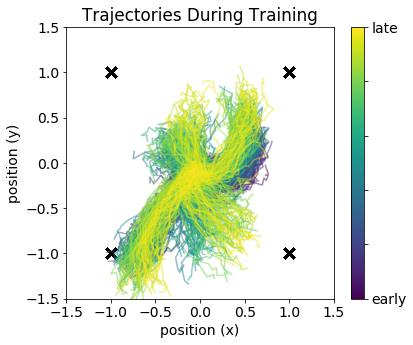

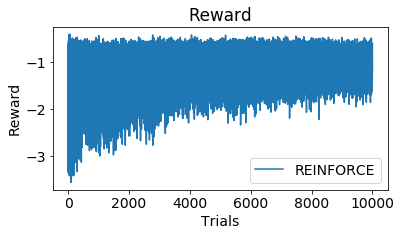

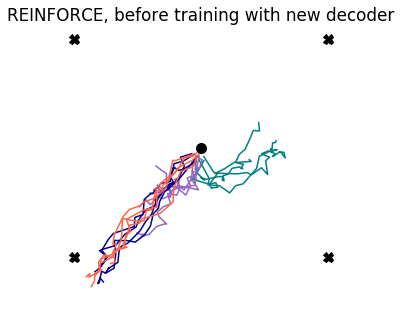

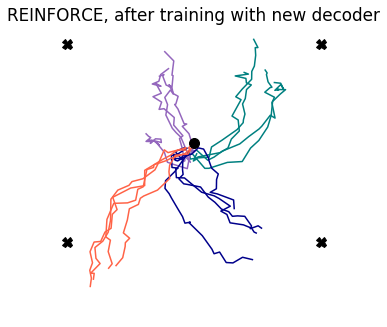

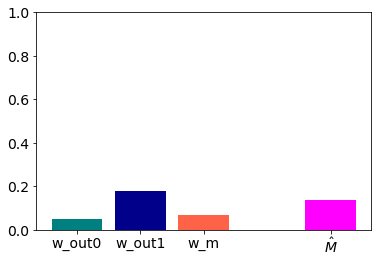

10it [00:00, 95.65it/s]

M norm: 1.38	 M angle: 0.60, 14 iterations
w_out1 norm: 1.38	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.81	 w_out1 vs. w_m angle: 0.44
w_m norm: 1.15	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.32	 w_out1 vs. Mhat angle: 0.41

500it [00:05, 89.88it/s]
10000it [03:31, 47.29it/s]
500it [00:07, 63.81it/s]


AR early fit 0.977, late fit 0.981


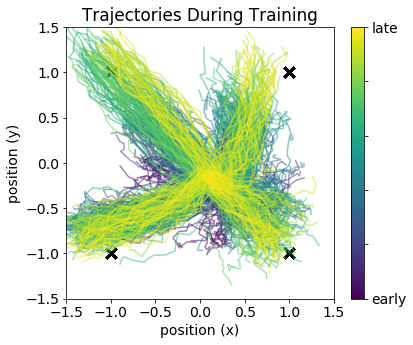

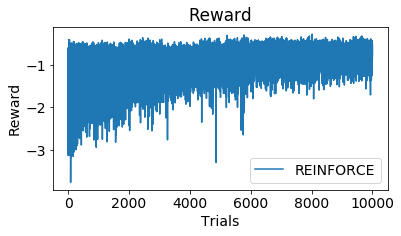

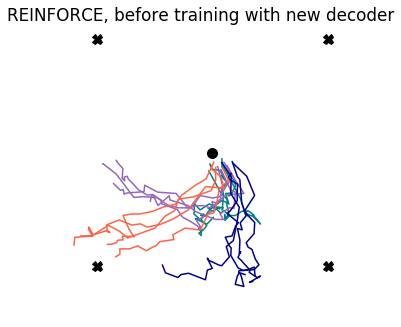

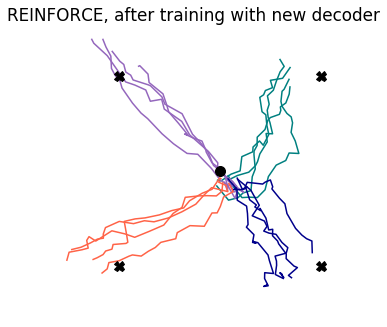

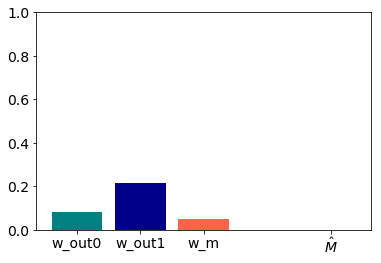

NO OVERLAP M angle: 0.92, 918 iterations

5it [00:00, 40.04it/s]

M norm: 1.04	 M angle: 0.79, 956 iterations
w_out1 norm: 1.04	 w_out vs. w_out1 angle: 0.79
w_m norm: 1.55	 w_out1 vs. w_m angle: 0.62
w_m norm: 1.15	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.35	 w_out1 vs. Mhat angle: 0.51

500it [00:08, 56.99it/s]
10000it [03:36, 46.23it/s]
500it [00:07, 67.77it/s]


AR early fit 0.978, late fit 0.983


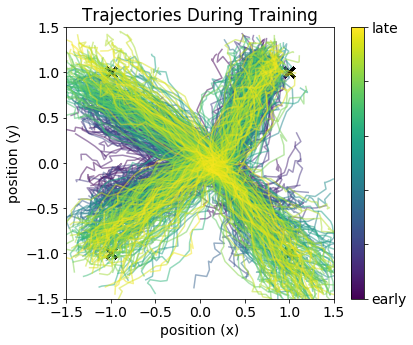

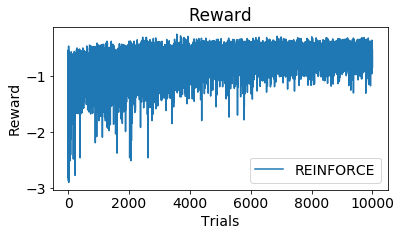

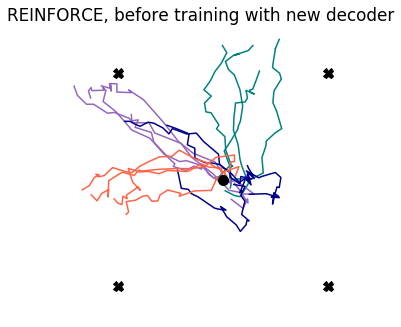

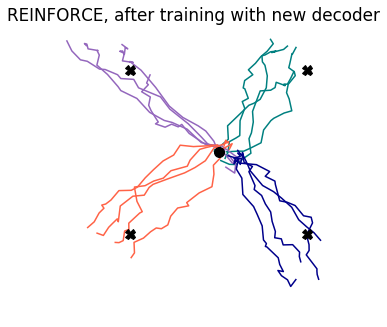

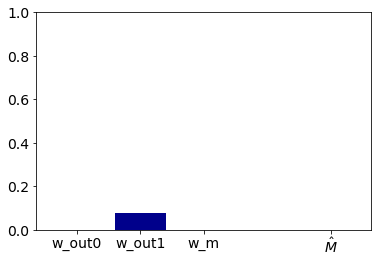

3it [00:00, 28.52it/s]

M norm: 1.75	 M angle: 0.20, 7 iterations
w_out1 norm: 1.75	 w_out vs. w_out1 angle: 0.20
w_m norm: 2.06	 w_out1 vs. w_m angle: 0.11
w_m norm: 1.15	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.33	 w_out1 vs. Mhat angle: 0.16

500it [00:08, 58.12it/s]
10000it [03:21, 49.60it/s]
500it [00:08, 58.27it/s]


AR early fit 0.977, late fit 0.980


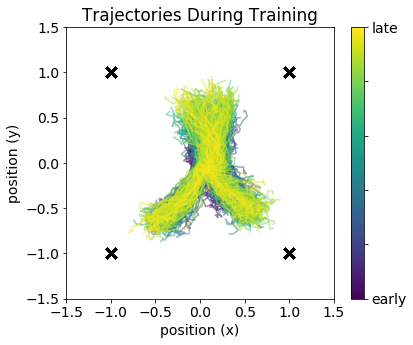

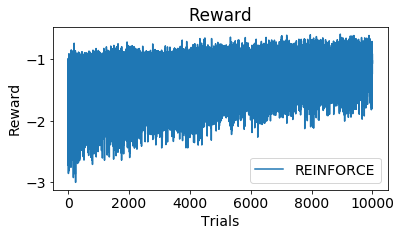

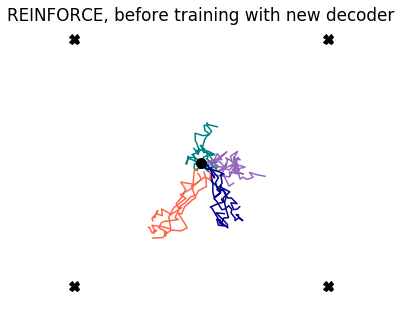

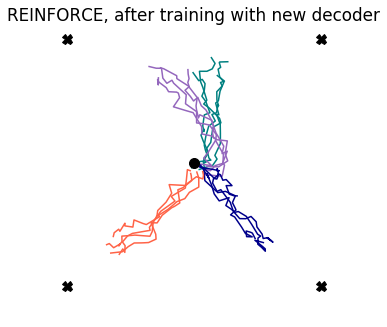

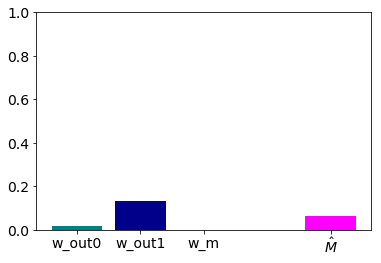

5it [00:00, 45.56it/s]

M norm: 1.62	 M angle: 0.39, 15 iterations
w_out1 norm: 1.62	 w_out vs. w_out1 angle: 0.39
w_m norm: 2.02	 w_out1 vs. w_m angle: 0.24
w_m norm: 1.15	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.51	 w_out1 vs. Mhat angle: 0.12

500it [00:06, 75.53it/s]
10000it [03:25, 48.69it/s]
500it [00:09, 51.18it/s]


AR early fit 0.975, late fit 0.977


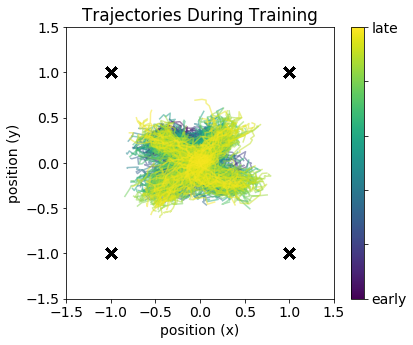

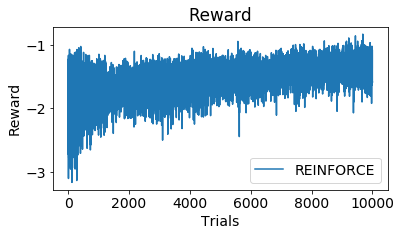

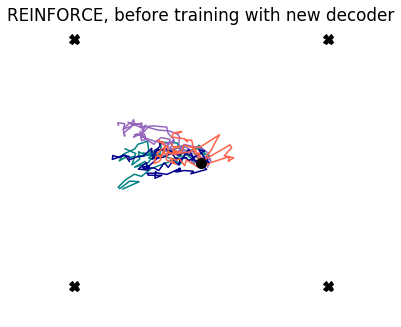

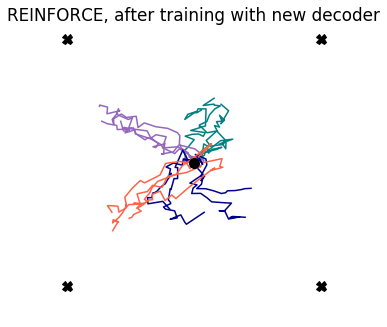

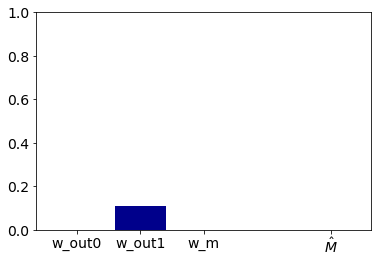

10it [00:00, 91.50it/s]

M norm: 1.37	 M angle: 0.60, 28 iterations
w_out1 norm: 1.37	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.68	 w_out1 vs. w_m angle: 0.53
w_m norm: 1.15	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.27	 w_out1 vs. Mhat angle: 0.45

500it [00:06, 73.04it/s]
10000it [02:39, 62.71it/s]
500it [00:04, 121.39it/s]


AR early fit 0.977, late fit 0.981


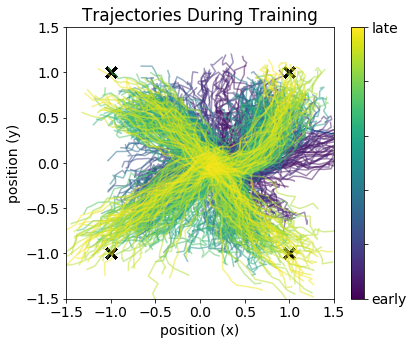

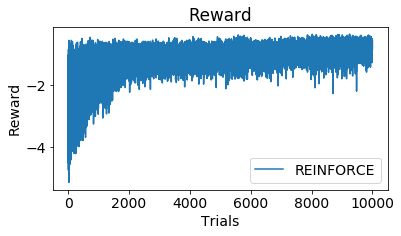

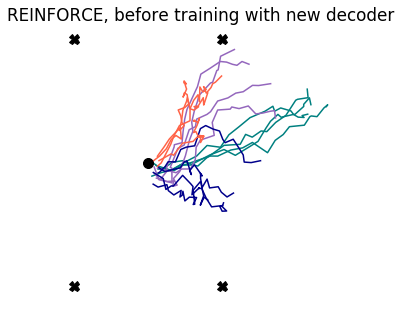

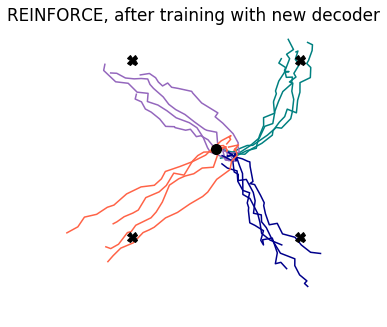

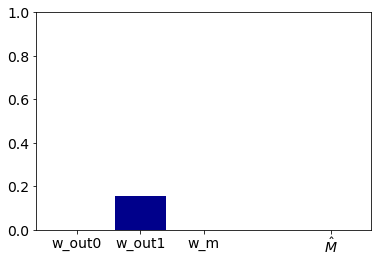

6it [00:00, 58.81it/s]

M norm: 1.00	 M angle: 0.81, 617 iterations
w_out1 norm: 1.00	 w_out vs. w_out1 angle: 0.81
w_m norm: 1.44	 w_out1 vs. w_m angle: 0.68
w_m norm: 1.15	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.34	 w_out1 vs. Mhat angle: 0.53

500it [00:04, 116.78it/s]
10000it [01:52, 89.00it/s]
500it [00:04, 124.75it/s]


AR early fit 0.980, late fit 0.981


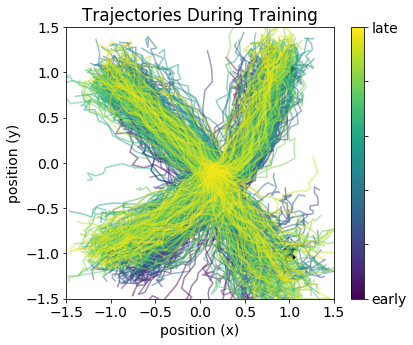

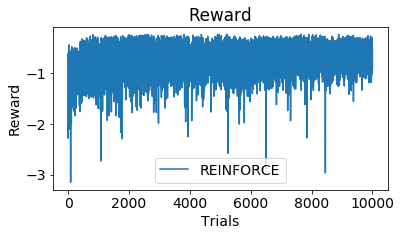

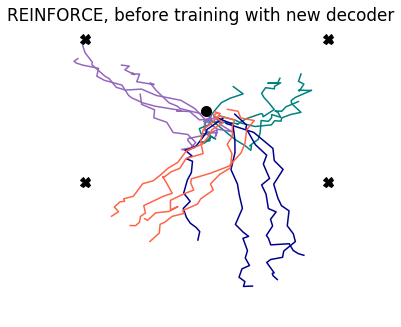

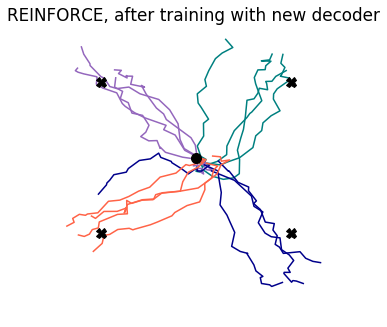

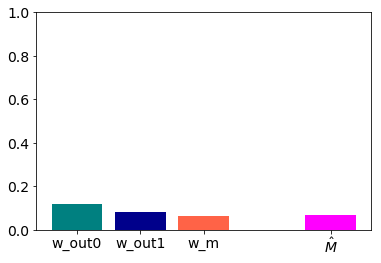

13it [00:00, 125.93it/s]

M norm: 1.75	 M angle: 0.19, 2 iterations
w_out1 norm: 1.75	 w_out vs. w_out1 angle: 0.19
w_m norm: 2.04	 w_out1 vs. w_m angle: 0.14
w_m norm: 1.15	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.28	 w_out1 vs. Mhat angle: 0.21

500it [00:03, 125.20it/s]
10000it [01:51, 89.58it/s]
500it [00:04, 124.33it/s]


AR early fit 0.976, late fit 0.979


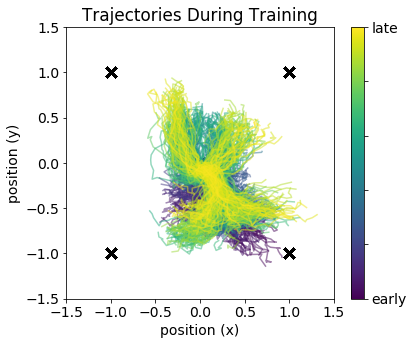

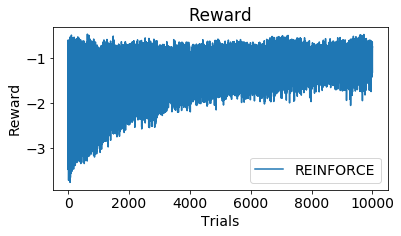

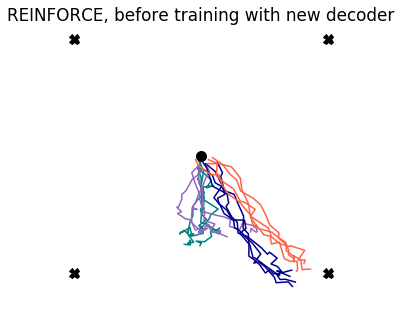

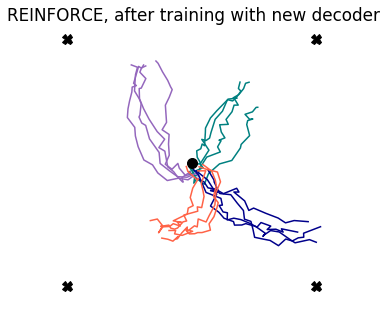

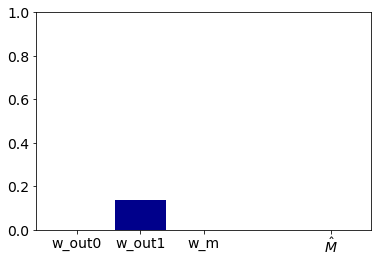

7it [00:00, 67.58it/s]

M norm: 1.61	 M angle: 0.41, 165 iterations
w_out1 norm: 1.61	 w_out vs. w_out1 angle: 0.41
w_m norm: 1.94	 w_out1 vs. w_m angle: 0.30
w_m norm: 1.15	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.36	 w_out1 vs. Mhat angle: 0.28

500it [00:04, 116.52it/s]
10000it [01:53, 88.22it/s]
500it [00:03, 125.20it/s]


AR early fit 0.976, late fit 0.980


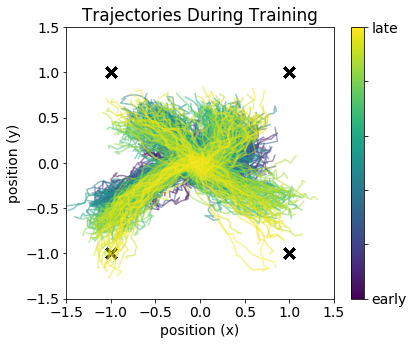

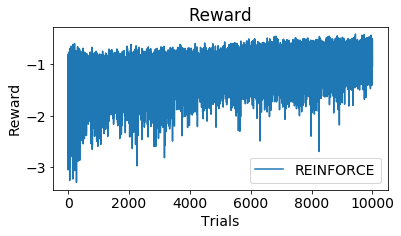

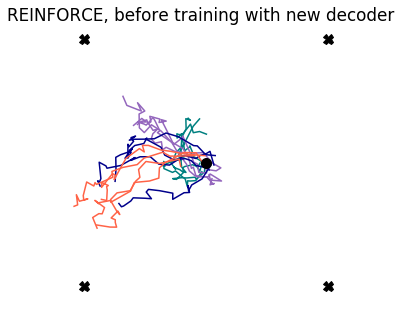

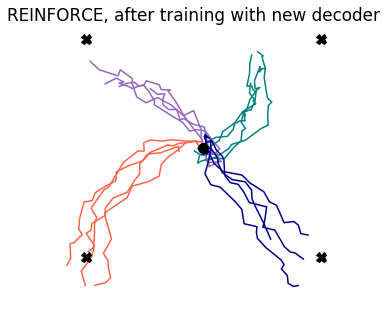

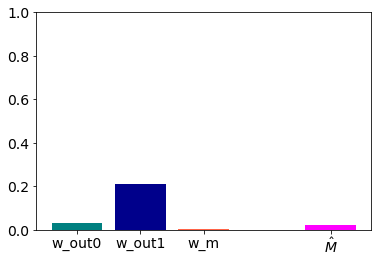

13it [00:00, 121.59it/s]

M norm: 1.36	 M angle: 0.61, 5 iterations
w_out1 norm: 1.36	 w_out vs. w_out1 angle: 0.61
w_m norm: 1.80	 w_out1 vs. w_m angle: 0.45
w_m norm: 1.15	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.35	 w_out1 vs. Mhat angle: 0.39

500it [00:04, 124.81it/s]
10000it [01:52, 88.74it/s]
500it [00:04, 123.73it/s]


AR early fit 0.977, late fit 0.980


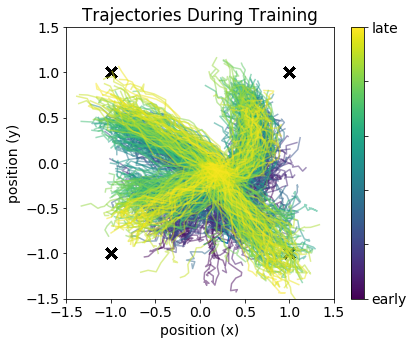

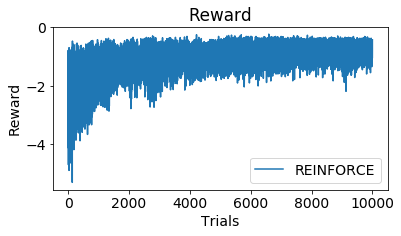

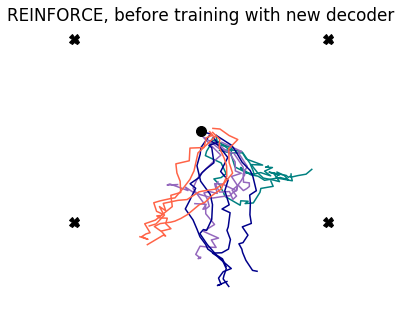

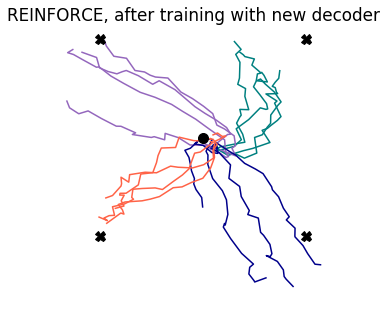

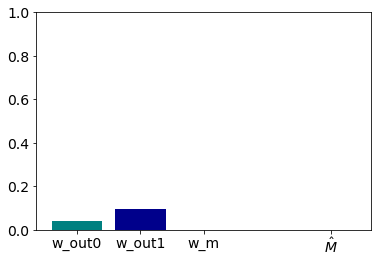

6it [00:00, 53.92it/s]

M norm: 0.99	 M angle: 0.81, 639 iterations
w_out1 norm: 0.99	 w_out vs. w_out1 angle: 0.81
w_m norm: 1.52	 w_out1 vs. w_m angle: 0.64
w_m norm: 1.15	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.36	 w_out1 vs. Mhat angle: 0.49

500it [00:04, 116.18it/s]
10000it [01:52, 88.71it/s]
500it [00:04, 124.92it/s]


AR early fit 0.979, late fit 0.982


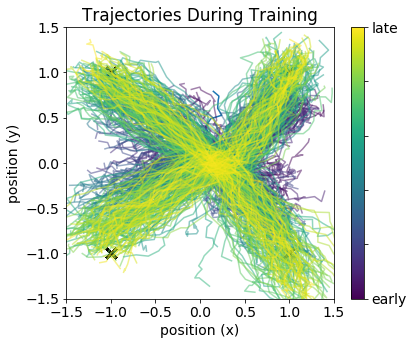

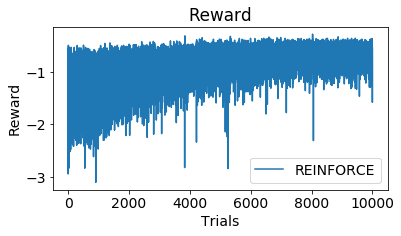

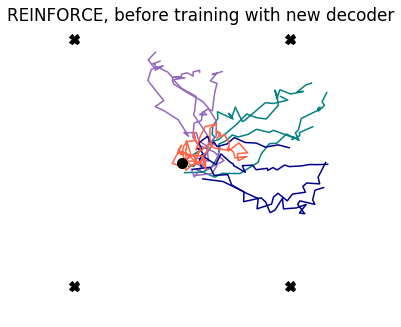

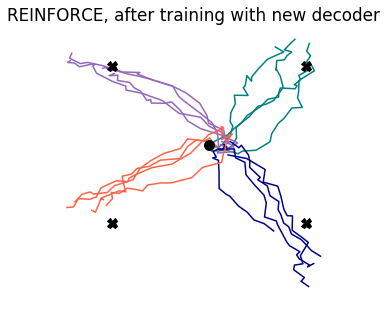

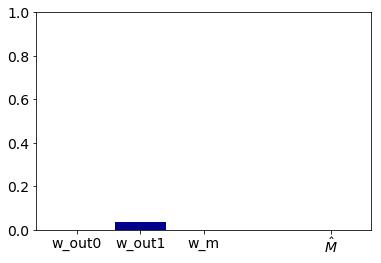

13it [00:00, 123.45it/s]

M norm: 1.77	 M angle: 0.20, 1 iterations
w_out1 norm: 1.77	 w_out vs. w_out1 angle: 0.20
w_m norm: 2.03	 w_out1 vs. w_m angle: 0.18
w_m norm: 1.15	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.42	 w_out1 vs. Mhat angle: 0.08

500it [00:04, 124.90it/s]
10000it [01:53, 88.30it/s]
500it [00:03, 125.56it/s]


AR early fit 0.976, late fit 0.980


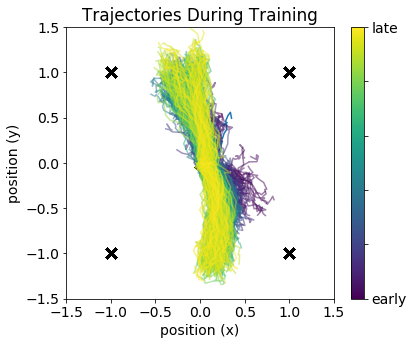

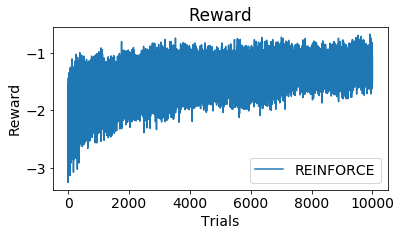

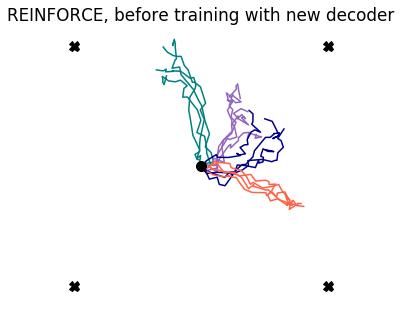

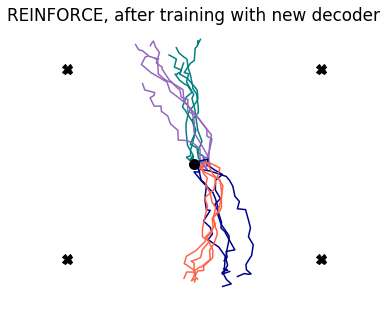

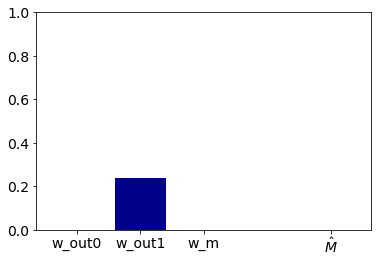

7it [00:00, 64.36it/s]

M norm: 1.60	 M angle: 0.40, 216 iterations
w_out1 norm: 1.60	 w_out vs. w_out1 angle: 0.40
w_m norm: 1.90	 w_out1 vs. w_m angle: 0.33
w_m norm: 1.15	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.25	 w_out1 vs. Mhat angle: 0.38

500it [00:04, 122.16it/s]
10000it [01:52, 89.01it/s]
500it [00:03, 125.11it/s]


AR early fit 0.978, late fit 0.981


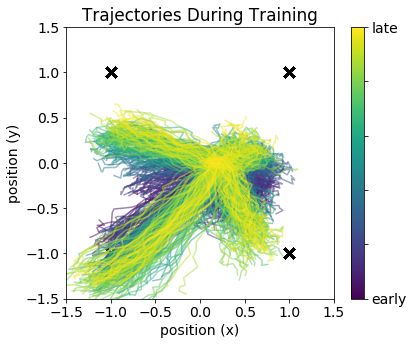

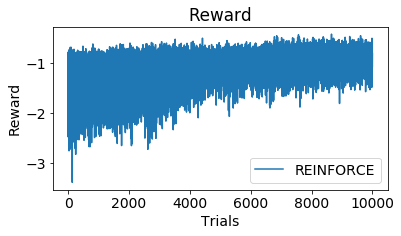

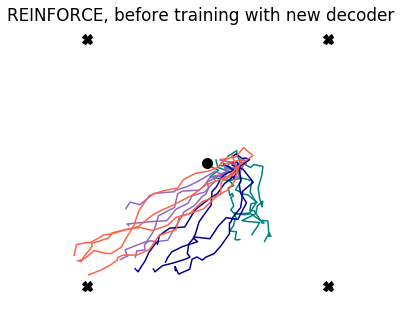

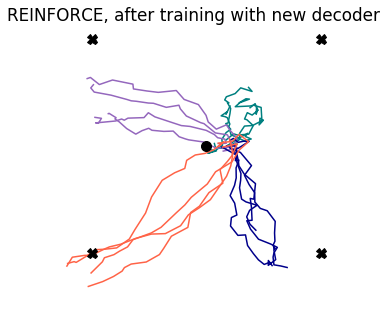

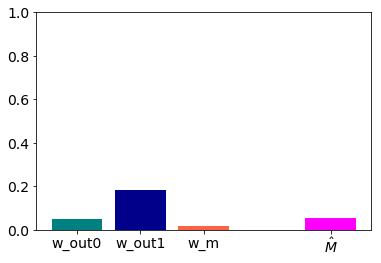

12it [00:00, 113.63it/s]

M norm: 1.35	 M angle: 0.61, 1 iterations
w_out1 norm: 1.35	 w_out vs. w_out1 angle: 0.61
w_m norm: 1.77	 w_out1 vs. w_m angle: 0.46
w_m norm: 1.15	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.42	 w_out1 vs. Mhat angle: 0.30

500it [00:04, 124.74it/s]
10000it [01:54, 87.48it/s]
500it [00:04, 124.84it/s]


AR early fit 0.978, late fit 0.980


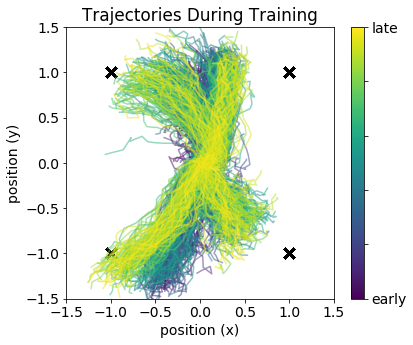

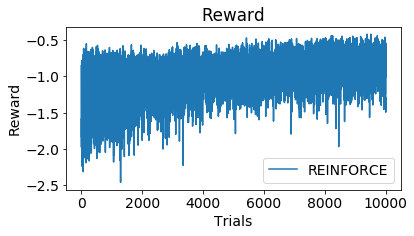

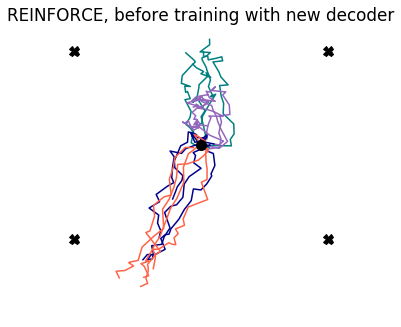

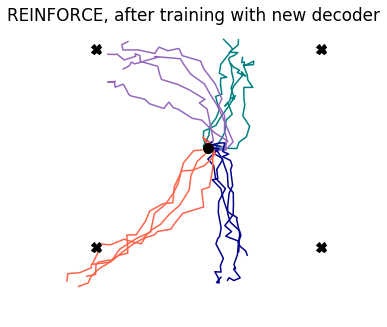

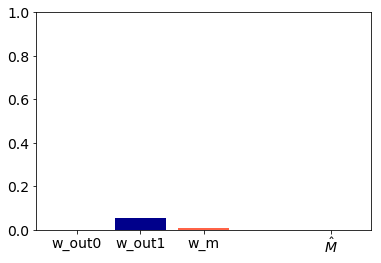

6it [00:00, 55.03it/s]

M norm: 1.00	 M angle: 0.81, 215 iterations
w_out1 norm: 1.00	 w_out vs. w_out1 angle: 0.81
w_m norm: 1.49	 w_out1 vs. w_m angle: 0.65
w_m norm: 1.15	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.28	 w_out1 vs. Mhat angle: 0.57

500it [00:04, 122.58it/s]
10000it [01:52, 89.05it/s]
500it [00:04, 124.73it/s]


AR early fit 0.980, late fit 0.982


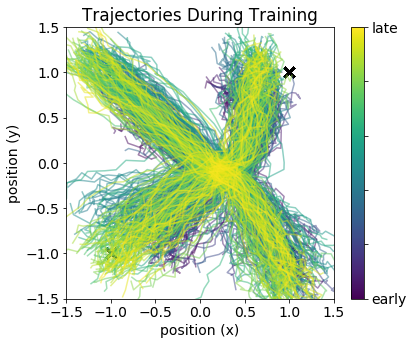

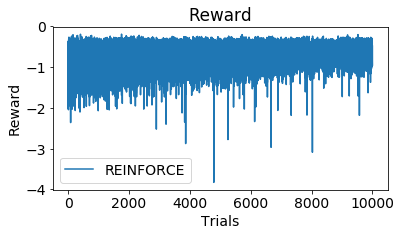

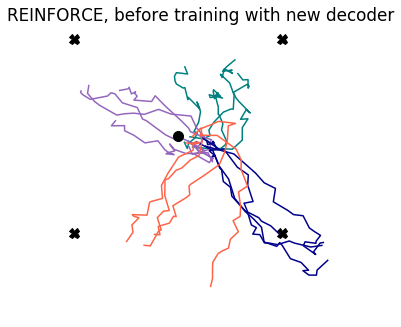

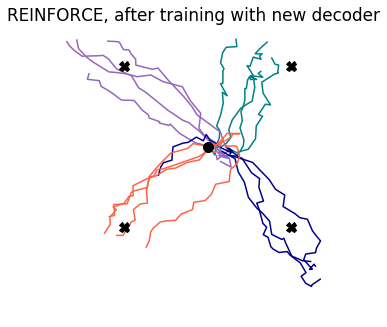

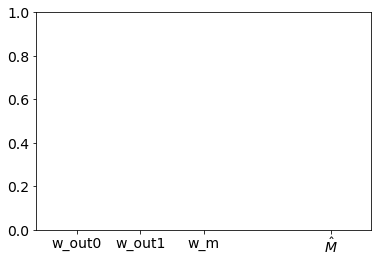

In [6]:


# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.2,eta_out=0.1,eta_fb=0.1,g_fb=2,
               sig_in=0.0,sig_rec=0.2,sig_out=0.01,sig_fb=0.01,
               velocity_transform=False, tau_vel = 0.8, dt_vel = 0.1,
               driving_feedback=True,
               rng=np.random.RandomState(72))
params.print_params()

scale=5

# Initialize RNN
net0 = RNN(params)
sim0 = Simulation(net0)

"""" SHOULD OVERLAP HERE BE SAME AS ABOVE FOR RFLO 0.5 and 50 ?? """
w_m = choose_aligned_matrix(net0.w_out.T,n_change=20,overlap=0.8,rng=np.random.RandomState(56),zero=False,tolerance=0.01,loop=1000)

""" set M and Wfb to be equal """
net0.set_weights(w_m = w_m, w_fb = scale*w_m)

rflo = RFLO(net0,apply_to=['w_rec'],online=False)
sim0.run_session(n_trials=5000, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['loss','h'], plot=True, plot_freq=20)

fig0 = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4],title='Pretrain RFLO, train '+r'$W_{rec}$')






""" Apply PCA to static activity, Estimate Mhat """
net0_post = RNN(params)
net0_post.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy(),w_fb = net0.w_fb.copy(),w_m = net0.w_m.copy())
sim0_post = Simulation(net0_post)
trackvars = TrackVars(net0_post,apply_to=[]) 
sim0_post.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err','pos'], plot=False, plot_freq=10)

# concatenate data
activity = sim0_post.session_probes['h'][0].squeeze()
print(activity.shape)

for i in range(1,len(sim0_post.session_probes['h'])):
    activity = np.vstack((activity,sim0_post.session_probes['h'][i].squeeze()))
    
print('n_samples,n_features: ',activity.shape)

""" Apply PCA """
pca = PCA(n_components=10)
pca.fit(activity)
C = pca.components_

print('C: ',pca.components_.shape)
fig,ax = plt.subplots()
#plt.plot(pca.explained_variance_/np.sum(pca.explained_variance_),'o-') # same dealio
plt.plot(pca.explained_variance_ratio_,'o-')
plt.ylabel('explained variance')
plt.xlabel('PC')
plt.show()


""" Compare with cursor location """
pos = sim0_post.session_probes['pos'][0].squeeze()
print(pos.shape)

for i in range(1,len(sim0_post.session_probes['pos'])):
    pos = np.vstack((pos,sim0_post.session_probes['pos'][i].squeeze()))
print(pos.shape)

lr = LinearRegression(fit_intercept=False)
lr.fit((C @ activity.T).T, pos)
D = lr.coef_

print(D.shape)

Mhat = (D@C).T






""" Average over multiple seeds """
seeds = [0,1,3,55,1917] #,1,12,54,72,81]
overlaps = [0.2,0.4,0.6,0.8]
n_changes = [80,60,50,15]
train_duration = 10000


stats = {}
stats['corr1'] = []
stats['corr2'] = []
stats['corr3'] = []
stats['corr4'] = []
stats['corrcoef'] = []

stats['seeds'] = seeds
stats['overlaps'] = overlaps
stats['n_changes'] = n_changes
stats['scale_w_fb'] = scale
stats['train_duration'] = train_duration
stats['frac_on'] = frac_on
stats['RNNparams'] = params

for seed in seeds:

    corr1_list = []
    corr2_list = []
    corr3_list = []
    corr4_list = []
    corrcoef_list = []


    for overlap,n_change in zip(overlaps,n_changes):
        
        w_out1 = choose_aligned_matrix(net0.w_out.copy(),n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)

        # confirm overlap between w_out1 and w_out
        norm, angle = return_norm_and_angle(net0.w_out,w_out1)
        print('\nw_out1 norm: {:.2f}'.format(norm) + '\t w_out vs. w_out1 angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out1 and w_m
        norm, angle = return_norm_and_angle(w_out1,w_m.T)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out1 vs. w_m angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out and w_m
        norm, angle = return_norm_and_angle(net0.w_out,w_m.T)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out vs. w_m angle: {:.2f}'.format(angle),end='')
        
        # confirm overlap between w_out and w_m
        norm, angle = return_norm_and_angle(w_out1,Mhat.T)
        print('\nw_out1 norm: {:.2f}'.format(norm) + '\t w_out1 vs. Mhat angle: {:.2f}'.format(angle),end='')
        
        
        
        
        net1_pre = RNN(params)
        net1_pre.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy(), w_fb = net0.w_fb.copy())
        net1_pre.set_weights(w_out = w_out1)
        net1_pre.set_weights(w_m = net0.w_m.copy()) # still use true w_m

        # unfortunately I need to make a different network to maintain integrity of pre and post simulations for plotting
        net1 = RNN(params)
        net1.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy(), w_fb = net0.w_fb.copy())
        net1.set_weights(w_out = w_out1)
        net1.set_weights(w_m = net0.w_m.copy()) # still use true w_m




        """ Track activity with new decoder, before training """

        sim1_pre = Simulation(net1_pre)
        trackvars = TrackVars(net1_pre,apply_to=[]) 
        sim1_pre.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)
        #fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

        """ Train with new decoder """

        sim1_train = Simulation(net1)
        reinforce = REINFORCE(net1,apply_to=['w_rec'],online=False,tau_reward=5)
        sim1_train.run_session(n_trials=train_duration, tasks=[task1,task2,task3,task4], learn_alg=[reinforce], probe_types=['h','reward','err'], plot=True, plot_freq=10)

        """ Track activity with new decoder, after training """
        net1_post = RNN(params)
        net1_post.set_weights(w_in=net1.w_in.copy(), w_rec=net1.w_rec.copy(), w_fb = net1.w_fb.copy())
        net1_post.set_weights(w_out = net1.w_out.copy())
        net1_post.set_weights(w_m = net1.w_m.copy())

        sim1_post = Simulation(net1_post)
        trackvars = TrackVars(net1_post,apply_to=[]) 
        sim1_post.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)

        
        fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='REINFORCE, before training with new decoder')

        fig = plot_trained_trajectories(sim=sim1_post, tasks=[task1,task2,task3,task4],title='REINFORCE, after training with new decoder')
        
        
        """ Calculate F fields """
        F_early, score_early = flow_field_data(sim1_pre.session_probes['h'])
        F_late, score_late = flow_field_data(sim1_post.session_probes['h'])

        print('AR early fit {:.3f}, late fit {:.3f}'.format(score_early,score_late))

        Fdata = F_late - F_early

        # separate train and test data from sim1_train
        n_total = len(sim1_train.session_probes['h'])
        n_train = int(0.5 * n_total)
        idx_train = np.random.RandomState(1975+seed).choice(np.arange(0,n_total),size=n_train,replace=False).astype(int)
        idx_test = np.arange(0,n_total)[~idx_train].astype(int)
        #idx_test=idx_train

        h_train = np.asarray(sim1_train.session_probes['h'])[idx_train,:,:,:]
        err_train = np.asarray(sim1_train.session_probes['err'])[idx_train,:,:,:]

        Fpred_w_out = flow_field_predicted(net0.w_out,err_train,h_train)
        Fpred_w_out1 = flow_field_predicted(w_out1,err_train,h_train)
        Fpred_w_m = flow_field_predicted(net1.w_m.T,err_train,h_train) # NOTE Mhat is USED HERE TO PREDICT
        Fpred_w_Mhat = flow_field_predicted(Mhat.T,err_train,h_train) # NOTE Mhat is USED HERE TO PREDICT

        h_test = np.asarray(sim1_train.session_probes['h'])[idx_test,:,:,:]

        corr1 = calculate_flow_field_correlation(Fpred_w_out,Fdata,h_test) # could also sample sim_test
        corr1_list.append(corr1)

        corr2 = calculate_flow_field_correlation(Fpred_w_out1,Fdata,h_test) # could also sample sim_test
        corr2_list.append(corr2)

        corr3 = calculate_flow_field_correlation(Fpred_w_m,Fdata,h_test) # could also sample sim_test
        corr3_list.append(corr3)
        
        corr4 = calculate_flow_field_correlation(Fpred_w_Mhat,Fdata,h_test) # could also sample sim_test
        corr4_list.append(corr4)
        
        fig,ax = plt.subplots(1,1)
        plt.bar([0,1,2,4],[corr1,corr2,corr3,corr4],tick_label=['w_out0','w_out1','w_m',r'$\hat{M}$'],color=['teal','darkblue','tomato','magenta'])
        plt.ylim([0,1])
        plt.show()
        
        
        
        
        
        
      
        
    # update
    stats['corr1'].append(corr1_list)
    stats['corr2'].append(corr2_list)
    stats['corr3'].append(corr3_list)
    stats['corr4'].append(corr4_list)
    #stats['corrcoef'].append(corrcoef_list)



In [7]:
stats_reinforce_mhat = stats
stats_reinforce_mhat['params'] = params


""" save stats """
save = True
tag = '5-19-v1'

if save:
    
    with open(folder+'stats_reinforce_mhat'+tag+'.pickle', 'wb') as handle:
        pickle.dump(stats_reinforce_mhat, handle, protocol=pickle.HIGHEST_PROTOCOL)

        print('>>>>GOOD MORNING, THIS SAVED PROPERLY')

>>>>GOOD MORNING, THIS SAVED PROPERLY


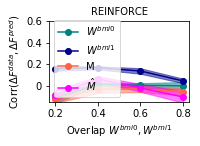

In [8]:
""" Plot Estimate of M"""

save = True
paper = True


x = overlaps
n_samples = np.asarray(stats['corr1']).shape[0]
mn1 = np.mean(np.asarray(stats['corr1']).T,axis=1)
mn2 = np.mean(np.asarray(stats['corr2']).T,axis=1)
mn3 = np.mean(np.asarray(stats['corr3']).T,axis=1)
mn4 = np.mean(np.asarray(stats['corr4']).T,axis=1)
std1 = np.std(np.asarray(stats['corr1']).T,axis=1)
std2 = np.std(np.asarray(stats['corr2']).T,axis=1)
std3 = np.std(np.asarray(stats['corr3']).T,axis=1)
std4 = np.std(np.asarray(stats['corr4']).T,axis=1)
sem1 = np.std(np.asarray(stats['corr1']).T,axis=1)/np.sqrt(n_samples)
sem2 = np.std(np.asarray(stats['corr2']).T,axis=1)/np.sqrt(n_samples)
sem3 = np.std(np.asarray(stats['corr3']).T,axis=1)/np.sqrt(n_samples)
sem4 = np.std(np.asarray(stats['corr4']).T,axis=1)/np.sqrt(n_samples)

fig,ax = plt.subplots(1,1)


plt.plot(x,mn1,'o-',color='teal',label=r'$W^{bmi0}$')
plt.plot(x,mn2,'o-',color='darkblue',label=r'$W^{bmi1}$')
plt.plot(x,mn3,'o-',color='tomato',label='M')
plt.plot(x,mn4,'o-',color='magenta',label=r'$\hat{M}$')
plt.fill_between(x,mn1-sem1,mn1+sem1,alpha=0.5,color='teal')
plt.fill_between(x,mn2-sem2,mn2+sem2,alpha=0.5,color='darkblue')
plt.fill_between(x,mn3-sem3,mn3+sem3,alpha=0.5,color='tomato')
plt.fill_between(x,mn4-sem4,mn4+sem4,alpha=0.5,color='magenta')



plt.title('REINFORCE')
plt.ylabel('Corr('+r'$\Delta F^{data},\Delta F^{pred})$')
plt.xlabel('Overlap '+r'$W^{bmi0},W^{bmi1}$')
plt.ylim([-0.15,0.6])
#plt.xlim([-50,1400])
plt.legend()

if paper:
    fig,ax = paper_format(fig=fig,ax=ax,xlabels=None,ylabels=[0,0.2,0.4,0.6,0.8,1],linewidth=2,ylim=[-0.15,0.6],figsize=(2.25,3))

plt.show()

if save:
    fig.savefig(folder+'fig4-reinforce-Mhat.pdf')

In [1]:
stats_reinforce_mhat

NameError: name 'stats_reinforce_mhat' is not defined